#MOGP LMC/ICM

In [ ]:
import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib
import json, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize


base_path = Path("/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn")


if str(base_path ) not in sys.path:
    sys.path.insert(0, str(base_path ))

os.chdir(base_path )

from helpers_od_calibration_BN import load_kwargs_config
from src.simulation.data_loader import od_xml_to_df
from src.simulation.sumo_runner import create_taz_xml, simulate_od, parse_loop_data_xml_to_pandas
from src.utils.link_flow_analysis import (
    compute_squared_metric_all_edge as compute_squared_metric_all_edge ,
    compute_squared_metric_per_edge as compute_squared_metric_all_edge ,
)
%matplotlib inline


config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 20,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# create GT scenario 

In [2]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)



Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml
Total GT demand: 2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv


In [3]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)


# Run simulation
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count
0  taz91  taz93  500.0
1  taz91  taz94  500.0
2  taz92  taz93  900.0
3  taz92  taz94  900.0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --du

In [4]:
df_edge_gt, df_trips_raw, out_csv = parse_loop_data_xml_to_pandas(
    base_path,
    sim_edge_out_gt,   # '.../ground_truth/sim_edge_data_quickstart.xml'
    prefix_output_gt,  # '.../ground_truth/sim'
    config["SUMO_PATH"],
)

print(df_edge_gt.head())
print(df_trips_raw.columns)

num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)


  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250
Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')
Number of GT edges: 14


In [5]:
print(num_gt_edges)

14


In [6]:
print(df_trips_raw.columns)


#edge_speed', 'edge_speedRelative','edge_timeLoss', 'edge_traveltime', 'edge_waitingTime','interval_nVehContrib', 'interval_harmonicMeanSpeed'

#other objectives

Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')


In [7]:
print(df_edge_gt.columns)

Index(['edge_id', 'interval_nVehContrib', 'interval_harmonicMeanSpeed'], dtype='object')


In [8]:
print(df_edge_gt.head())

  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250


In [9]:
gt_edge_data = df_edge_gt.sort_values(by=['interval_nVehContrib'], ascending=False).iloc[:num_gt_edges] # 14 


print(sim_edge_out_gt)

edge_ids = gt_edge_data["edge_id"].tolist()

gt_flows = (gt_edge_data.set_index("edge_id") # set index makes the edges IDs the dataframe index 
.loc[edge_ids, "interval_nVehContrib"]  #.loc[edge_ids, ...] = "Select rows where the index is in the edge_ids list and the col "interval_nVehContrib"
.values.astype(float)
) # gt_flow is a numpy array which is a vector of the flows on the edges 


L = len(edge_ids) # number of edges, 14
weights_np = np.ones(L) / L    # [1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L] with L= 14 
#  np.ones(L) Create a 1-dimensional array of length L with all elements equal to 1, and then each element of the array is divided by L to get the weights.

print("Using UNIFORM weights:")
for e, w in zip(edge_ids, weights_np):
    print(f"  {e}: weight = {w:.4f}")

output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml
Using UNIFORM weights:
  D4: weight = 0.0714
  L14: weight = 0.0714
  L4: weight = 0.0714
  D5: weight = 0.0714
  D7: weight = 0.0714
  L10: weight = 0.0714
  L18: weight = 0.0714
  L5: weight = 0.0714
  L7: weight = 0.0714
  D2: weight = 0.0714
  L12: weight = 0.0714
  L2: weight = 0.0714
  L16: weight = 0.0714
  L15: weight = 0.0714


In [10]:
print(gt_flows)

[1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]


In [11]:
print ("GT flows :", gt_flows[:])
print ("Weights :", weights_np[:])

GT flows : [1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]
Weights : [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


# sobol points 

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0] # dimension of the od vector
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)  # this is bound for the initial trainig points (od vector)



seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed)
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device)
print (x_0.shape)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)

print (train_X0) 
print (dim_od)

cpu
4
Random seed set to 42
torch.Size([20, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374],
        [ 208.3256, 1373.7338, 1810.7880,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4970],
        [1642.0144, 1849.8973, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8532, 1135.5953, 1953.6954],
        [  97.3469,   66.7411,  384.3306,  587.1246],
        [1006.2524, 1536.8247, 1885.7071, 1482.5537],
        [1357.3130,  396.7292, 1282.7886, 1120.7016],
        [ 257.9750, 1991.8317,  784.0896,  949.7550],
        [ 790.8787,  889.4018, 1532.9441, 1567.5589],
        [1824.3027, 1483.7563,   33.9629,  486.5554],
        [1770.7187,  937.5904, 1217.8479, 1300.8279],
        [ 860.3464, 1408.1616,  71

## evaluation of Sobol points

In [13]:
csv_path = Path(f"{config['simulation_run_path']}/initial_search/data_set_ods_icm_replicated.csv")

# Check if initial data already exists
if csv_path.exists():
    print(f"✓ Loading initial data from {csv_path}")
    df_initial = pd.read_csv(csv_path)
    
    # Extract data from CSV
    train_X_list = []
    train_E_list = []
    S_list = []
    
    # Get x_* columns (OD inputs) - sorted by number
    x_cols = [col for col in df_initial.columns if col.startswith('x_')]
    x_cols.sort(key=lambda x: int(x.split('_')[1]))
    
    # Get e_* columns (per-edge errors)
    e_cols = [col for col in df_initial.columns if col.startswith('e_')]
    
    # Load each row
    for idx, row in df_initial.iterrows():
        train_X_list.append(row[x_cols].values.astype(float))
        train_E_list.append(row[e_cols].values.astype(float))
        S_list.append(float(row['loss']))
    
    print(f"  Loaded {len(train_X_list)} initial points")
    print(f"  OD dimension: {len(x_cols)}, Edges: {len(e_cols)}")
    
else:
    print(f"✗ CSV not found. Running {config['n_init_search']} initial simulations...")
    
    train_X_list = []      # each: np.array, shape [dim_od]
    train_E_list = []      # each: np.array, shape [L] (per-edge errors)
    S_list       = []      # each: scalar aggregated loss

    batch_data_i = []      # for CSV / plotting
    N_REP = 1           

    for i, x in enumerate(train_X0.tolist()):
        print(f"Initial OD: {i}")
        curr_od = np.array(x, dtype=float)
        print(curr_od)
        print(f"total expected demand: {np.sum(curr_od)}")


        simulation_run_path_init = f"{config['simulation_run_path']}/initial_search"
        Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

        # OD xml for this candidate (same for all reps)
        new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
        prefix_output_base = f"{simulation_run_path_init}/sobol_{i}"

        
        base_od = gt_od_df.copy() 
        base_od["count"] = curr_od
        base_od["count"] = [round(v, 1) for v in base_od["count"]]
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        
        per_edge_errors_reps = []

        for rep in range(N_REP):
            print(f"    ▶ Replication {rep}")
            prefix_output_rep = f"{prefix_output_base}_rep{rep}"

            simulate_od(
                new_od_xml,
                prefix_output_rep,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
                sim_start_time=0,
                seed=rep,   # different seed per replication
            )

            sim_edge_out_rep = f"{prefix_output_rep}_{config['EDGE_OUT_STR']}"
            curr_loop_stats_rep, _, _ = parse_loop_data_xml_to_pandas(
                base_path,
                sim_edge_out_rep,
                prefix_output_rep,
                config["SUMO_PATH"],
            )

            # printing simulated flows per edge 
            sim_counts = (
                curr_loop_stats_rep[curr_loop_stats_rep["edge_id"].isin(edge_ids)]
                .set_index("edge_id")["interval_nVehContrib"]
                .loc[edge_ids]  # preserve order
                .values
            )

            print(f"\n--- Simulated flows for replication {rep} ---")
            for edge_id, count in zip(edge_ids, sim_counts):
                print(f"  {edge_id}: {count}")

            # per-edge error for this replication (e_l(x))
            per_edge_errors_rep = compute_nrmse_per_edge(
                df_true=gt_edge_data,
                df_simulated=curr_loop_stats_rep,
                edge_ids=edge_ids,
            )  # np.array [L]

            per_edge_errors_reps.append(per_edge_errors_rep)

        
        per_edge_errors_reps = np.stack(per_edge_errors_reps, axis=0)  # [N_REP, L]
        per_edge_errors = per_edge_errors_reps.mean(axis=0)            # [L]

        # aggregated scalar loss S(x) = Σ_l w_l e_l(x)
        S_x = float((per_edge_errors * weights_np).sum())
        print(f"aggregated loss S(x): {S_x}")

        
        train_X_list.append(curr_od.copy())
        train_E_list.append(per_edge_errors.copy())
        S_list.append(S_x)

        
        df_curr = pd.DataFrame(
            curr_od.reshape(1, -1),
            columns=[f"x_{k+1}" for k in range(curr_od.shape[0])]
        )
        df_curr["loss"] = S_x
        
        # Add per-edge errors as columns (e_edge_id for each edge)
        for edge_idx, edge_id in enumerate(edge_ids):
            df_curr[f"e_{edge_id}"] = per_edge_errors[edge_idx]
        
        batch_data_i.append(df_curr)

    # Save initial dataset
    df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
    df_initial_bo.to_csv(csv_path, index=False)
    print(f"✓ Saved initial data to {csv_path}")

✓ Loading initial data from output/quickstart_bo_vanilla/initial_search/data_set_ods_icm_replicated.csv
  Loaded 20 initial points
  OD dimension: 4, Edges: 14


In [14]:
print (S_list )
print (train_X_list)

[1.5431797909153078, 0.8662538000215959, 0.0661608171903682, 1.275962487744304, 0.5627743271424971, 0.1864039238383183, 0.0434194783500701, 2.0360066192635786, 0.8334976954612531, 0.587408248749235, 0.4031089462261095, 1.3064210696109129, 0.5295852875139474, 0.6260342739085053, 0.4905883014433285, 1.8242497358816536, 1.4887928176942733, 0.4494707504229204, 0.4911170025915128, 1.4529777107943709]
[array([1995.02670765,  208.73278379, 1645.95770836,  838.86432648]), array([ 905.4017663 , 1676.13458633,  146.54093981, 1232.33985901]), array([ 436.36757135,  700.44517517, 1395.85351944,  347.93174267]), array([1463.98448944, 1168.59400272,  896.61258459, 1706.4114809 ]), array([1172.46508598,  780.60382605,  309.82995033, 1819.23735142]), array([ 208.32563937, 1373.73375893, 1810.78803539,  236.28084362]), array([ 738.9138937 ,  257.48419762,  559.97943878, 1367.49696732]), array([1642.01438427, 1849.89726543, 1060.6096983 ,  702.4101615 ]), array([1538.64121437,  590.48742056,  634.409785

# ICM CLEAN

# fitting gp 

In [15]:
import torch
import numpy as np
from pathlib import Path
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from MOGP.helpers_MOGP import initialize_icm_gp, LinearAggregationICM
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries

In [16]:
dtype  = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_X_icm = torch.tensor(np.array(train_X_list),
                           dtype=dtype, device=device)   # [N, d]

# Raw per-edge errors meaning no standardization 
train_Y_icm_raw = torch.tensor(np.array(train_E_list),
                               dtype=dtype, device=device)   # [N, L]

# Standardize outputs per edge for GP stability
y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

N, d = train_X_icm.shape
L    = train_Y_icm.shape[1]

max_demand = 2000.0
bounds = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.full((d,), max_demand, dtype=dtype, device=device),
])

train_X_norm = normalize(train_X_icm, bounds=bounds)


icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=2) # gp fitting is on standardize data 

icm_model     = icm_model.to(device=device, dtype=dtype)
icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
mll           = mll.to(device=device, dtype=dtype)


weights_uniform = torch.ones(L, dtype=dtype, device=device)
weights_uniform = weights_uniform / weights_uniform.sum()


agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

icm_model.train()
mll.train()

#fit_gpytorch_mll(mll)   


fit_gpytorch_mll_with_retries(mll, max_retries=3, base_jitter=1e-3, jitter_multiplier=10.0, verbose=True)

print("Initial ICM fit done.")

ICM fit successful on attempt 1 (jitter=0.0e+00).
Initial ICM fit done.


# inspecting the inital paramters 

In [17]:
print(train_Y_icm)

tensor([[-0.3796, -0.3796, -0.3796,  3.3480, -0.9402, -0.9402,  3.3480,  3.3480,
         -0.9402, -0.1989, -0.1989, -0.1989, -1.0863,  2.4211],
        [-0.6749, -0.6749, -0.6749, -0.6479,  1.3735,  1.3735, -0.6479, -0.6479,
          1.3735,  0.3723,  0.3723,  0.3723, -0.7480, -0.6250],
        [-0.8509, -0.8509, -0.8509, -0.5951, -0.9402, -0.9402, -0.5951, -0.5951,
         -0.9402, -0.9775, -0.9775, -0.9775, -0.1362, -0.8602],
        [-0.2021, -0.2021, -0.2021,  0.0043,  1.2676,  1.2676,  0.0043,  0.0043,
          1.2676,  0.4633,  0.4633,  0.4633,  0.9579,  0.5006],
        [-0.7447, -0.7447, -0.7447, -0.7418,  0.4714,  0.4714, -0.7418, -0.7418,
          0.4714, -0.4945, -0.4945, -0.4945,  1.5681, -0.2021],
        [-0.7929, -0.7929, -0.7929, -0.4358, -1.0260, -1.0260, -0.4358, -0.4358,
         -1.0260, -0.8033, -0.8033, -0.8033,  0.2938, -0.7409],
        [-0.8375, -0.8375, -0.8375, -0.7389, -1.0185, -1.0185, -0.7389, -0.7389,
         -1.0185, -0.9875, -0.9875, -0.9875, -0.4

In [18]:
print("train_Y shape:", train_Y_icm.shape)            
print("model num_tasks:", icm_model.num_tasks)        
print("likelihood num_tasks:", icm_model.likelihood.num_tasks) 

train_Y shape: torch.Size([20, 14])
model num_tasks: 14
likelihood num_tasks: 14


In [19]:

S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

best_S_raw = S_all_raw.min().item()
best_S_std = S_all_std.min().item()

print("Initial S values (raw):", S_all_raw.cpu().numpy())
print(f"Initial best S (raw) = {best_S_raw:.6f}")
print(f"Initial best S (std) = {best_S_std:.6f}")

S_history_raw     = [best_S_raw]
S_obs_history_raw = S_all_raw.cpu().tolist()
S_history_std     = [best_S_std]


Initial S values (raw): [1.5431798  0.86625385 0.06616082 1.2759625  0.56277436 0.18640393
 0.04341948 2.0360067  0.83349776 0.5874083  0.40310895 1.306421
 0.52958536 0.6260343  0.49058837 1.8242497  1.4887929  0.44947076
 0.49111703 1.4529779 ]
Initial best S (raw) = 0.043419
Initial best S (std) = -0.852600


In [20]:

#ONE BO ITERATION


print("\n BO ITERATION")

# Put model in eval mode
icm_model.eval()
agg_model.eval()


EI = ExpectedImprovement(
    model=agg_model,
    best_f=best_S_std,
    maximize=False
)


bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


#acquisition
x_next_norm, acq_val = optimize_acqf(
    EI,
    bounds=bounds_norm, # search space constraint between 0 and 1
    q=1, # batch 
    num_restarts=config["NUM_RESTARTS"],
    raw_samples=config["RAW_SAMPLES"],
)

x_next_norm = x_next_norm.detach()

with torch.no_grad():
    post = agg_model.posterior(x_next_norm)
    mu_next = post.mean.item()
    std_next = post.variance.sqrt().item()

print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
print(f"[ACQ] Predicted S = {mu_next:.4f} ± {std_next:.4f}")

# Convert to REAL OD (0..2000)
x_next_real = unnormalize(x_next_norm, bounds).view(-1).cpu().numpy()
print(f"[ACQ] x_next (real scale) = {x_next_real}")


 BO ITERATION
[ACQ] x_next_norm = [[0.82274175 0.01073295 0.00093205 0.0475394 ]]
[ACQ] Predicted S = -0.3473 ± 0.0920
[ACQ] x_next (real scale) = [1645.4835      21.465908     1.8640943   95.0788   ]


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [21]:
from pathlib import Path
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
from src.utils.seed import set_seed
import numpy as np


N_init, d      = train_X_icm.shape
L              = train_Y_icm.shape[1]

N_RESTARTS = 3
N_BO_ITERS = 100

bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

train_X_icm_init = train_X_icm.clone()
train_Y_icm_raw_init = train_Y_icm_raw.clone()

icm_histories_raw = []
icm_histories_std = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"      ICM RESTART {r+1}/{N_RESTARTS}")
    print("============================\n")
    
    
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")

    # Reset data to initial samples
    train_X_icm = train_X_icm_init.clone()
    train_Y_icm_raw = train_Y_icm_raw_init.clone()

    # Standardize outputs per edge (fixed stats per restart)
    y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
    y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
    train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

    # Normalize inputs
    train_X_norm = normalize(train_X_icm, bounds=bounds)

    # Init ICM model
    icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=2)
    icm_model = icm_model.to(device=device, dtype=dtype)
    icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
    mll = mll.to(device=device, dtype=dtype)

    agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

    # Initial best S
    S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
    S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

    best_S_raw = S_all_raw.min().item()
    best_S_std = S_all_std.min().item()

    S_history_raw = [best_S_raw]
    S_history_std = [best_S_std]
    S_obs_history_raw = S_all_raw.detach().cpu().tolist()

    # BO LOOP
    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"       ICM BO ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")

        icm_model.eval()
        agg_model.eval()

        EI = ExpectedImprovement(
            model=agg_model,
            best_f=best_S_std,
            maximize=False,  
        )

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )
        x_next_norm = x_next_norm.detach()

        with torch.no_grad():
            post_next = agg_model.posterior(x_next_norm)
            mu_next   = post_next.mean.item()
            std_next  = post_next.variance.sqrt().item()

        print(f"[ACQ] EI value = {acq_val.item():.6f}")
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Predicted S(x_next) ≈ {mu_next:.6f} ± {std_next:.6f}")

        # Map to REAL OD space
        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")
        print(f"[ACQ] Total demand = {x_next_real.sum():.2f}")

        # SUMO
        sim_dir = f"{config['simulation_run_path']}/icm_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        print("\nOD COMPARISON")
        gt_od  = gt_od_df['count'].astype(float).values
        sim_od = x_next_real
        for idx, (gt_val, sim_val) in enumerate(zip(gt_od, sim_od)):
            print(f"  OD pair {idx:02d}: GT = {gt_val:8.2f}   SIM = {sim_val:8.2f}")
        print("Total GT demand :", gt_od.sum())
        print("Total SIM demand:", sim_od.sum())
        print("================================================\n")

        # Per-edge errors
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        e_next = compute_nrmse_per_edge(
            df_true=gt_edge_data,
            df_simulated=curr_loop_stats,
            edge_ids=edge_ids,
        )

        e_next_tensor = torch.tensor(e_next, device=device, dtype=dtype)
        e_next_std = (e_next_tensor - y_mean) / y_std

        print("\n[SIM] Per-edge errors e_next:")
        for eid, e_val in zip(edge_ids, e_next):
            print(f"  edge {eid}: e = {e_val:.6f}")

        # Aggregated S
        S_next_raw = (e_next_tensor * weights_uniform).sum()
        S_next_std = (e_next_std * weights_uniform).sum()
        S_next_val = S_next_raw.item()
        print(f"[SIM] S(x_next) = {S_next_val:.6f}")

        S_obs_history_raw.append(S_next_val)

        # Update training data
        train_X_icm = torch.cat(
            [train_X_icm,
             torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_icm_raw = torch.cat(
            [train_Y_icm_raw, e_next_tensor.view(1, -1)],
            dim=0,
        )
        train_Y_icm = torch.cat(
            [train_Y_icm, e_next_std.view(1, -1)],
            dim=0,
        )

        train_X_norm = normalize(train_X_icm, bounds=bounds)

        # Refit ICM GP
        icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=2)
        icm_model = icm_model.to(device=device, dtype=dtype)
        icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
        mll = mll.to(device=device, dtype=dtype)

        agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

        icm_model.train()
        mll.train()
        fit_gpytorch_mll_with_retries(
            mll,
            max_retries=3,
            base_jitter=1e-3,
            jitter_multiplier=10.0,
            verbose=True,
        )

    
        if S_next_val < best_S_raw:
            print(f"[UPDATE] New BEST S (raw): {S_next_val:.6f} (previous {best_S_raw:.6f})")
            best_S_raw = S_next_val
        else:
            print(f"[NO IMPROVEMENT] Best raw remains = {best_S_raw:.6f}")

        if S_next_std.item() < best_S_std:
            best_S_std = S_next_std.item()

        S_history_raw.append(best_S_raw)
        S_history_std.append(best_S_std)

    icm_histories_raw.append(S_history_raw)
    icm_histories_std.append(S_history_std)

# Mean curve across restarts (raw)
min_len = min(len(h) for h in icm_histories_raw)
S_history_raw = np.mean([h[:min_len] for h in icm_histories_raw], axis=0).tolist()

print("\nFinished ICM BO.")
print(f"Final best S (raw, mean) = {S_history_raw[-1]:.6f}")



      ICM RESTART 1/3

[SEED] Set seed to 42 for restart 1


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03655947 0.3775279  0.9768473  0.0147137 ]]
[ACQ] Predicted S(x_next) ≈ -0.235074 ± 0.132071
[ACQ] Candidate OD (real space) = [  73.11895   755.0558   1953.6946     29.427393]
[ACQ] Total demand = 2811.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibr

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2811 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.61s
 Real time factor: 94581.3
 UPS: 1926781.609195
Vehicles:
 Inserted: 2811
 Running: 0
 Waiting: 0
Statistics (avg of 2811):
 RouteLength: 4006.76
 Speed: 9.66
 Duration: 417.44
 WaitingTime: 0.28
 TimeLoss: 124.63
 DepartDelay: 763.94
DijkstraRouter answered 5451 queries and explored 9.14 edges on average.
Dijkstra

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1868 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.45s
 Real time factor: 128000
 UPS: 1684855.555556
Vehicles:
 Inserted: 1868
 Running: 0
 Waiting: 0
Statistics (avg of 1868):
 RouteLength: 4358.45
 Speed: 10.76
 Duration: 405.88
 WaitingTime: 0.20
 TimeLoss: 87.19
 DepartDelay: 893.59
DijkstraRouter answered 3664 queries and explored 10.55 edges on average.
Dijkstra

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 3/100

[ACQ] EI value = 0.034688
[ACQ] x_next_norm = [[1. 0. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ -0.122742 ± 0.611244
[ACQ] Candidate OD (real space) = [2000.    0.    0. 2000.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quick

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.075653
[ACQ] x_next_norm = [[0.23591214 0.         0.         1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.586692 ± 0.444419
[ACQ] Candidate OD (real space) = [ 471.82428    0.         0.      2000.     ]
[ACQ] Total demand = 2471.82
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/s

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes rou

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.081925
[ACQ] x_next_norm = [[0.         0.5499982  0.47156706 0.3115183 ]]
[ACQ] Predicted S(x_next) ≈ -0.886357 ± 0.159019
[ACQ] Candidate OD (real space) = [   0.      1099.9965   943.13416  623.0366 ]
[ACQ] Total demand = 2666.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.058002
[ACQ] x_next_norm = [[0.00000000e+00 1.00000000e+00 1.31080135e-17 0.00000000e+00]]
[ACQ] Predicted S(x_next) ≈ -0.223024 ± 0.652026
[ACQ] Candidate OD (real space) = [0.0000000e+00 2.0000000e+03 2.6216027e-14 0.0000000e+00]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/s

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.075411
[ACQ] x_next_norm = [[0.4237113 0.        0.9671395 0.       ]]
[ACQ] Predicted S(x_next) ≈ -0.628780 ± 0.409280
[ACQ] Candidate OD (real space) = [ 847.4226    0.     1934.2789    0.    ]
[ACQ] Total demand = 2781.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 11/100

[ACQ] EI value = 0.013530
[ACQ] x_next_norm = [[0.         1.         0.06610556 1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.339532 ± 0.367038
[ACQ] Candidate OD (real space) = [   0.      2000.       132.21112 2000.     ]
[ACQ] Total demand = 4132.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.000795
[ACQ] x_next_norm = [[0.        0.        0.8113709 0.6580442]]
[ACQ] Predicted S(x_next) ≈ -0.415796 ± 0.193371
[ACQ] Candidate OD (real space) = [   0.        0.     1622.7418 1316.0884]
[ACQ] Total demand = 2938.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1563 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.39s
 Real time factor: 148454
 UPS: 2148708.762887
Vehicles:
 Inserted: 1563
 Running: 0
 Waiting: 0
Statistics (avg of 1563):
 RouteLength: 4948.60
 Speed: 9.31
 Duration: 533.40
 WaitingTime: 0.46
 TimeLoss: 171.23
 DepartDelay: 720.57
DijkstraRouter answered 3051 queries and explored 12.89 edges on average.
Dijkstr

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 14/100

[ACQ] EI value = 0.000142
[ACQ] x_next_norm = [[0.52526855 0.         1.         1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.309733 ± 0.193214
[ACQ] Candidate OD (real space) = [1050.5371    0.     2000.     2000.    ]
[ACQ] Total demand = 5050.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.18
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 15/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.021042
[ACQ] x_next_norm = [[0.         0.         0.80202603 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.683473 ± 0.195698
[ACQ] Candidate OD (real space) = [   0.        0.     1604.0521    0.    ]
[ACQ] Total demand = 1604.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.53
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 16/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.004615
[ACQ] x_next_norm = [[0.12505801 0.36416787 0.4083839  0.38673776]]
[ACQ] Predicted S(x_next) ≈ -0.770780 ± 0.071222
[ACQ] Candidate OD (real space) = [250.11603 728.33575 816.7678  773.4755 ]
[ACQ] Total demand = 2568.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2169 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.42s
 Real time factor: 138129
 UPS: 2250323.741007
Vehicles:
 Inserted: 2169
 Running: 0
 Waiting: 0
Statistics (avg of 2169):
 RouteLength: 4478.20
 Speed: 10.40
 Duration: 432.63
 WaitingTime: 0.32
 TimeLoss: 105.68
 DepartDelay: 455.75
DijkstraRouter answered 4166 queries and explored 11.01 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   800.56
  OD pair 01: GT =   500.00   SIM =   390.40
  OD pair 02: GT =   900.00   SIM =   654.24
  OD pair 03: GT =   900.00   SIM =   323.84
Total GT demand : 2800.0
Total SIM demand: 2169.0432


[SIM] Per-edge errors e_next:
  edge D4: e = 0.208544
  edge L14: e = 0.208544
  edge L4: e = 0.208544
  edge D5: e = 0.001543
  edge D7: e = 0.240100
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.035539


       ICM BO ITER 18/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.033648
[ACQ] x_next_norm = [[0.         0.74996907 0.71908486 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.754243 ± 0.207974
[ACQ] Candidate OD (real space) = [   0.     1499.9381 1438.1697    0.    ]
[ACQ] Total demand = 2938.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.031639
[ACQ] x_next_norm = [[0. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ -0.401639 ± 0.445867
[ACQ] Candidate OD (real space) = [   0. 2000. 2000.    0.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.035539


       ICM BO ITER 20/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.028530
[ACQ] x_next_norm = [[0.31053534 0.2920239  0.45296082 0.43573025]]
[ACQ] Predicted S(x_next) ≈ -0.894696 ± 0.056488
[ACQ] Candidate OD (real space) = [621.0707  584.0478  905.92163 871.4605 ]
[ACQ] Total demand = 2982.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[UPDATE] New BEST S (raw): 0.015392 (previous 0.035539)


       ICM BO ITER 21/100

[ACQ] EI value = 0.080339
[ACQ] x_next_norm = [[0.73764473 0.         0.         0.6283246 ]]
[ACQ] Predicted S(x_next) ≈ -0.656913 ± 0.454168
[ACQ] Candidate OD (real space) = [1475.2894    0.        0.     1256.6493]
[ACQ] Total demand = 2731.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/q

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.015392


       ICM BO ITER 22/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.015109
[ACQ] x_next_norm = [[0.         0.4279591  0.7108661  0.33239818]]
[ACQ] Predicted S(x_next) ≈ -0.816957 ± 0.123698
[ACQ] Candidate OD (real space) = [   0.      855.9182 1421.7322  664.7963]
[ACQ] Total demand = 2942.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.015392


       ICM BO ITER 23/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.010270
[ACQ] x_next_norm = [[0.3371425  0.         0.47243017 0.41283125]]
[ACQ] Predicted S(x_next) ≈ -0.790544 ± 0.123759
[ACQ] Candidate OD (real space) = [674.285     0.      944.86035 825.6625 ]
[ACQ] Total demand = 2444.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.015392


       ICM BO ITER 24/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.013970
[ACQ] x_next_norm = [[0.1804356  0.33541453 0.53753775 0.40162453]]
[ACQ] Predicted S(x_next) ≈ -0.884563 ± 0.065419
[ACQ] Candidate OD (real space) = [ 360.8712   670.82904 1075.0756   803.2491 ]
[ACQ] Total demand = 2910.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.007722 (previous 0.015392)


       ICM BO ITER 25/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003101
[ACQ] x_next_norm = [[0.35148785 0.67266077 0.78933436 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.590546 ± 0.188356
[ACQ] Candidate OD (real space) = [ 702.9757 1345.3215 1578.6687    0.    ]
[ACQ] Total demand = 3626.97
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.007722


       ICM BO ITER 26/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05416741 0.7493436  0.67671573 0.04455167]]
[ACQ] Predicted S(x_next) ≈ -0.462075 ± 0.047762
[ACQ] Candidate OD (real space) = [ 108.33482 1498.6871  1353.4315    89.10335]
[ACQ] Total demand = 3049.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1816 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.34s
 Real time factor: 171940
 UPS: 2437976.119403
Vehicles:
 Inserted: 1816
 Running: 0
 Waiting: 0
Statistics (avg of 1816):
 RouteLength: 4501.39
 Speed: 10.11
 Duration: 449.74
 WaitingTime: 0.34
 TimeLoss: 120.53
 DepartDelay: 361.39
DijkstraRouter answered 3438 queries and explored 11.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   752.18
  OD pair 01: GT =   500.00   SIM =   295.31
  OD pair 02: GT =   900.00   SIM =   536.31
  OD pair 03: GT =   900.00   SIM =   233.13
Total GT demand : 2800.0
Total SIM demand: 1816.9353


[SIM] Per-edge errors e_next:
  edge D4: e = 0.328074
  edge L14: e = 0.328074
  edge L4: e = 0.328074
  edge D5: e = 0.006400
  edge D7: e = 0.387951
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.007722


       ICM BO ITER 28/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.003460
[ACQ] x_next_norm = [[0.14520779 0.         0.57053226 0.3226929 ]]
[ACQ] Predicted S(x_next) ≈ -0.828087 ± 0.072060
[ACQ] Candidate OD (real space) = [ 290.4156    0.     1141.0646  645.3858]
[ACQ] Total demand = 2076.87
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.007722


       ICM BO ITER 29/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.007000
[ACQ] x_next_norm = [[0.        0.        0.4088101 1.       ]]
[ACQ] Predicted S(x_next) ≈ -0.364283 ± 0.335827
[ACQ] Candidate OD (real space) = [   0.         0.       817.62024 2000.     ]
[ACQ] Total demand = 2817.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.007722


       ICM BO ITER 30/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.23702583 0.29170617 0.3916627  0.4307394 ]]
[ACQ] Predicted S(x_next) ≈ -0.744850 ± 0.034827
[ACQ] Candidate OD (real space) = [474.05167 583.41235 783.3254  861.4788 ]
[ACQ] Total demand = 2702.27
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.005097 (previous 0.007722)


       ICM BO ITER 31/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001294
[ACQ] x_next_norm = [[0.2660102  0.10234818 0.3967846  0.5269603 ]]
[ACQ] Predicted S(x_next) ≈ -0.859603 ± 0.039903
[ACQ] Candidate OD (real space) = [ 532.0204   204.69635  793.5692  1053.9207 ]
[ACQ] Total demand = 2584.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.005097


       ICM BO ITER 32/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.021325
[ACQ] x_next_norm = [[0.42453694 0.17865236 0.3229522  0.51517355]]
[ACQ] Predicted S(x_next) ≈ -0.912903 ± 0.058818
[ACQ] Candidate OD (real space) = [ 849.0739   357.30472  645.9044  1030.3472 ]
[ACQ] Total demand = 2882.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.005097


       ICM BO ITER 33/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.011206
[ACQ] x_next_norm = [[0.24575146 0.22505672 0.4709313  0.46472207]]
[ACQ] Predicted S(x_next) ≈ -0.915343 ± 0.030058
[ACQ] Candidate OD (real space) = [491.5029  450.11343 941.8626  929.44415]
[ACQ] Total demand = 2812.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.52
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.001344 (previous 0.005097)


       ICM BO ITER 34/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003145
[ACQ] x_next_norm = [[0.56327766 0.         0.2358428  0.7114064 ]]
[ACQ] Predicted S(x_next) ≈ -0.788875 ± 0.092463
[ACQ] Candidate OD (real space) = [1126.5553     0.       471.68558 1422.8129 ]
[ACQ] Total demand = 3021.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 35/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.08375146 0.4347664  0.8103597  0.00834558]]
[ACQ] Predicted S(x_next) ≈ -0.700976 ± 0.050715
[ACQ] Candidate OD (real space) = [ 167.50293   869.53284  1620.7195     16.691156]
[ACQ] Total demand = 2674.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 36/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000010
[ACQ] x_next_norm = [[0.21812212 0.00404666 0.31539863 0.57770973]]
[ACQ] Predicted S(x_next) ≈ -0.784169 ± 0.044918
[ACQ] Candidate OD (real space) = [ 436.24426    8.09332  630.79724 1155.4194 ]
[ACQ] Total demand = 2230.55
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 37/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.010074
[ACQ] x_next_norm = [[0.29437113 0.25129184 0.39986026 0.49257267]]
[ACQ] Predicted S(x_next) ≈ -0.929166 ± 0.014875
[ACQ] Candidate OD (real space) = [588.74225 502.58368 799.7205  985.1453 ]
[ACQ] Total demand = 2876.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 38/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000031
[ACQ] x_next_norm = [[1.         0.16149771 0.17246622 0.4926081 ]]
[ACQ] Predicted S(x_next) ≈ -0.196013 ± 0.222917
[ACQ] Candidate OD (real space) = [2000.       322.99542  344.93243  985.2162 ]
[ACQ] Total demand = 3653.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.18
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 39/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000374
[ACQ] x_next_norm = [[0.26712924 0.03380328 0.6287077  0.6155359 ]]
[ACQ] Predicted S(x_next) ≈ -0.712392 ± 0.091861
[ACQ] Candidate OD (real space) = [ 534.2585    67.60655 1257.4154  1231.0718 ]
[ACQ] Total demand = 3090.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 40/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.04607597 0.38267422 0.49250466 0.319119  ]]
[ACQ] Predicted S(x_next) ≈ -0.806538 ± 0.024790
[ACQ] Candidate OD (real space) = [ 92.15195 765.34845 985.00934 638.23804]
[ACQ] Total demand = 2480.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 41/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000037
[ACQ] x_next_norm = [[0.29031527 0.15000759 0.247773   0.64345753]]
[ACQ] Predicted S(x_next) ≈ -0.864379 ± 0.023111
[ACQ] Candidate OD (real space) = [ 580.63055  300.01517  495.54602 1286.915  ]
[ACQ] Total demand = 2663.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 42/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01014185 0.90169436 0.85301524 0.56457525]]
[ACQ] Predicted S(x_next) ≈ -0.000792 ± 0.175144
[ACQ] Candidate OD (real space) = [  20.283691 1803.3887   1706.0305   1129.1505  ]
[ACQ] Total demand = 4658.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 43/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.011184
[ACQ] x_next_norm = [[0.         0.31788236 0.53118074 0.5168397 ]]
[ACQ] Predicted S(x_next) ≈ -0.825936 ± 0.109779
[ACQ] Candidate OD (real space) = [   0.      635.7647 1062.3615 1033.6793]
[ACQ] Total demand = 2731.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 44/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003478
[ACQ] x_next_norm = [[0.17300156 0.4209005  0.5551166  0.3453752 ]]
[ACQ] Predicted S(x_next) ≈ -0.896443 ± 0.031139
[ACQ] Candidate OD (real space) = [ 346.0031   841.80096 1110.2332   690.7504 ]
[ACQ] Total demand = 2988.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 45/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00570383 0.23709908 0.42203668 0.47105166]]
[ACQ] Predicted S(x_next) ≈ -0.812055 ± 0.015497
[ACQ] Candidate OD (real space) = [ 11.40767 474.19815 844.07336 942.10333]
[ACQ] Total demand = 2271.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with s

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 46/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.06335311 0.36925703 0.61717343 0.01342474]]
[ACQ] Predicted S(x_next) ≈ -0.704922 ± 0.048913
[ACQ] Candidate OD (real space) = [ 126.706215  738.51404  1234.3469     26.849474]
[ACQ] Total demand = 2126.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001344


       ICM BO ITER 47/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.009851
[ACQ] x_next_norm = [[0.265692   0.24019504 0.44365457 0.46120813]]
[ACQ] Predicted S(x_next) ≈ -0.930516 ± 0.013958
[ACQ] Candidate OD (real space) = [531.384   480.39008 887.30914 922.41626]
[ACQ] Total demand = 2821.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000390 (previous 0.001344)


       ICM BO ITER 48/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24556799 0.25911143 0.8857941  0.29103744]]
[ACQ] Predicted S(x_next) ≈ -0.673731 ± 0.033079
[ACQ] Candidate OD (real space) = [ 491.136    518.22284 1771.5883   582.0749 ]
[ACQ] Total demand = 3363.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-f

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 49/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.1

[ACQ] EI value = 0.004266
[ACQ] x_next_norm = [[0.44733295 0.         0.31169397 0.58149433]]
[ACQ] Predicted S(x_next) ≈ -0.884068 ± 0.043680
[ACQ] Candidate OD (real space) = [ 894.6659     0.       623.38794 1162.9886 ]
[ACQ] Total demand = 2681.04
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 50/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.3188301  0.30228594 0.24792837 0.38737497]]
[ACQ] Predicted S(x_next) ≈ -0.835119 ± 0.026433
[ACQ] Candidate OD (real space) = [637.6602  604.5719  495.85672 774.74994]
[ACQ] Total demand = 2512.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000142
[ACQ] x_next_norm = [[0.04666964 0.25832337 0.6100511  0.33708444]]
[ACQ] Predicted S(x_next) ≈ -0.852578 ± 0.031561
[ACQ] Candidate OD (real space) = [  93.33928  516.6467  1220.1022   674.1689 ]
[ACQ] Total demand = 2504.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 52/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000014
[ACQ] x_next_norm = [[0.3615028  0.4273244  0.2683889  0.58944607]]
[ACQ] Predicted S(x_next) ≈ -0.771632 ± 0.050577
[ACQ] Candidate OD (real space) = [ 723.0056  854.6488  536.7778 1178.8921]
[ACQ] Total demand = 3293.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 53/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3912379  0.05683383 0.02572899 0.679264  ]]
[ACQ] Predicted S(x_next) ≈ -0.780776 ± 0.016334
[ACQ] Candidate OD (real space) = [ 782.4758    113.66765    51.457977 1358.5281  ]
[ACQ] Total demand = 2306.13
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 54/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000067
[ACQ] x_next_norm = [[0.13345721 0.54390335 0.63180906 0.21652515]]
[ACQ] Predicted S(x_next) ≈ -0.840225 ± 0.034322
[ACQ] Candidate OD (real space) = [ 266.91443 1087.8066  1263.6182   433.0503 ]
[ACQ] Total demand = 3051.39
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 298.93
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 55/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.008858
[ACQ] x_next_norm = [[0.29710272 0.21042657 0.4047227  0.49300843]]
[ACQ] Predicted S(x_next) ≈ -0.928794 ± 0.012031
[ACQ] Candidate OD (real space) = [594.20544 420.85315 809.4454  986.01685]
[ACQ] Total demand = 2810.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 56/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001617
[ACQ] x_next_norm = [[0.48147455 0.13555261 0.21986233 0.54320997]]
[ACQ] Predicted S(x_next) ≈ -0.875496 ± 0.037365
[ACQ] Candidate OD (real space) = [ 962.9491   271.10522  439.72464 1086.4199 ]
[ACQ] Total demand = 2760.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 57/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4938333  0.06796306 0.04521352 0.960807  ]]
[ACQ] Predicted S(x_next) ≈ -0.631943 ± 0.065402
[ACQ] Candidate OD (real space) = [ 987.6666   135.92612   90.42703 1921.614  ]
[ACQ] Total demand = 3135.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 58/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.62302125 0.19812423 0.35603893 0.357758  ]]
[ACQ] Predicted S(x_next) ≈ -0.707606 ± 0.052237
[ACQ] Candidate OD (real space) = [1246.0425   396.24847  712.0779   715.516  ]
[ACQ] Total demand = 3069.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 59/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01828008 0.4212545  0.74282223 0.5557473 ]]
[ACQ] Predicted S(x_next) ≈ -0.686674 ± 0.039137
[ACQ] Candidate OD (real space) = [  36.560154  842.509    1485.6444   1111.4945  ]
[ACQ] Total demand = 3476.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.2952609  0.2854865  0.50700194 0.4768206 ]]
[ACQ] Predicted S(x_next) ≈ -0.856525 ± 0.020594
[ACQ] Candidate OD (real space) = [ 590.5218   570.97296 1014.00385  953.6412 ]
[ACQ] Total demand = 3129.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 61/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002772
[ACQ] x_next_norm = [[0.308638   0.24777265 0.51623976 0.4384607 ]]
[ACQ] Predicted S(x_next) ≈ -0.909865 ± 0.018905
[ACQ] Candidate OD (real space) = [ 617.276   495.5453 1032.4795  876.9214]
[ACQ] Total demand = 3022.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 62/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.42667842 0.01992261 0.27072576 0.93678755]]
[ACQ] Predicted S(x_next) ≈ -0.656725 ± 0.046683
[ACQ] Candidate OD (real space) = [ 853.3568     39.845222  541.45154  1873.5751  ]
[ACQ] Total demand = 3308.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.82ing time 56.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/sim_ --ignore-route-errors=true 

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 63/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2290389  0.38093886 0.53332496 0.15560792]]
[ACQ] Predicted S(x_next) ≈ -0.796196 ± 0.030799
[ACQ] Candidate OD (real space) = [ 458.0778   761.8777  1066.6499   311.21585]
[ACQ] Total demand = 2597.82
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 64/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002064
[ACQ] x_next_norm = [[0.36956775 0.22409412 0.34775475 0.51742405]]
[ACQ] Predicted S(x_next) ≈ -0.900179 ± 0.027345
[ACQ] Candidate OD (real space) = [ 739.1355   448.18823  695.5095  1034.8481 ]
[ACQ] Total demand = 2917.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 65/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[0.16939175 0.11322218 0.38719812 0.53747094]]
[ACQ] Predicted S(x_next) ≈ -0.873911 ± 0.015658
[ACQ] Candidate OD (real space) = [ 338.7835   226.44437  774.39624 1074.9419 ]
[ACQ] Total demand = 2414.57
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 66/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.735223   0.61468565 0.936951   0.08208749]]
[ACQ] Predicted S(x_next) ≈ 0.319754 ± 0.313168
[ACQ] Candidate OD (real space) = [1470.446   1229.3713  1873.902    164.17497]
[ACQ] Total demand = 4737.89
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrati

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 67/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03203886 0.5758809  0.3948492  0.41392103]]
[ACQ] Predicted S(x_next) ≈ -0.762568 ± 0.012890
[ACQ] Candidate OD (real space) = [  64.07772 1151.7617   789.6984   827.84204]
[ACQ] Total demand = 2833.38
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 68/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.007519
[ACQ] x_next_norm = [[1. 1. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ 1.845573 ± 1.303805
[ACQ] Candidate OD (real space) = [2000. 2000.    0. 2000.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 69/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2705898  0.12068999 0.55857056 0.4006707 ]]
[ACQ] Predicted S(x_next) ≈ -0.875979 ± 0.012754
[ACQ] Candidate OD (real space) = [ 541.1796   241.37997 1117.1411   801.34143]
[ACQ] Total demand = 2701.04
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 70/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005225
[ACQ] x_next_norm = [[0.21583188 0.28657344 0.46426782 0.44700173]]
[ACQ] Predicted S(x_next) ≈ -0.923593 ± 0.013867
[ACQ] Candidate OD (real space) = [431.66376 573.14685 928.53564 894.0035 ]
[ACQ] Total demand = 2827.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 71/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001875
[ACQ] x_next_norm = [[0.321174   0.1441787  0.37194312 0.50109404]]
[ACQ] Predicted S(x_next) ≈ -0.916586 ± 0.012537
[ACQ] Candidate OD (real space) = [ 642.34796  288.35742  743.8862  1002.1881 ]
[ACQ] Total demand = 2676.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 72/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.30563724 0.29263285 0.39605153 0.6076308 ]]
[ACQ] Predicted S(x_next) ≈ -0.851576 ± 0.008202
[ACQ] Candidate OD (real space) = [ 611.2745  585.2657  792.103  1215.2616]
[ACQ] Total demand = 3203.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 73/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.1324258  0.29368135 0.66108215 0.49832776]]
[ACQ] Predicted S(x_next) ≈ -0.845311 ± 0.020972
[ACQ] Candidate OD (real space) = [ 264.8516   587.36273 1322.1643   996.6555 ]
[ACQ] Total demand = 3171.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 74/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000014
[ACQ] x_next_norm = [[0.16895874 0.07863206 0.4958304  0.5459446 ]]
[ACQ] Predicted S(x_next) ≈ -0.859431 ± 0.022797
[ACQ] Candidate OD (real space) = [ 337.91748  157.26413  991.66077 1091.8892 ]
[ACQ] Total demand = 2578.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 75/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.02970657 0.21650715 0.57805395 0.40363   ]]
[ACQ] Predicted S(x_next) ≈ -0.853293 ± 0.007927
[ACQ] Candidate OD (real space) = [  59.41315  433.0143  1156.1079   807.25995]
[ACQ] Total demand = 2455.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 76/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.15497832 0.37736073 0.5868757  0.24370319]]
[ACQ] Predicted S(x_next) ≈ -0.870584 ± 0.005752
[ACQ] Candidate OD (real space) = [ 309.95663  754.72144 1173.7513   487.40637]
[ACQ] Total demand = 2725.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 77/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.46011558 0.017315   0.20649819 0.5729085 ]]
[ACQ] Predicted S(x_next) ≈ -0.864968 ± 0.016066
[ACQ] Candidate OD (real space) = [ 920.23114    34.629993  412.99637  1145.817   ]
[ACQ] Total demand = 2513.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 78/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4990107  0.17218785 0.4428098  0.44985303]]
[ACQ] Predicted S(x_next) ≈ -0.843763 ± 0.014623
[ACQ] Candidate OD (real space) = [998.0214  344.3757  885.61957 899.70605]
[ACQ] Total demand = 3127.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 79/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[0.6956574  0.16574875 0.1091054  0.532201  ]]
[ACQ] Predicted S(x_next) ≈ -0.695109 ± 0.064842
[ACQ] Candidate OD (real space) = [1391.3147  331.4975  218.2108 1064.402 ]
[ACQ] Total demand = 3005.43
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 80/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.40318713 0.05937294 0.50110084 0.5860734 ]]
[ACQ] Predicted S(x_next) ≈ -0.834363 ± 0.019657
[ACQ] Candidate OD (real space) = [ 806.37427  118.74587 1002.20166 1172.1469 ]
[ACQ] Total demand = 3099.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 81/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000084
[ACQ] x_next_norm = [[0.24592376 0.32029402 0.53076714 0.3875927 ]]
[ACQ] Predicted S(x_next) ≈ -0.916578 ± 0.004500
[ACQ] Candidate OD (real space) = [ 491.8475  640.5881 1061.5343  775.1854]
[ACQ] Total demand = 2969.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000390


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005501
[ACQ] x_next_norm = [[0.23763317 0.26386043 0.45859626 0.4429729 ]]
[ACQ] Predicted S(x_next) ≈ -0.927863 ± 0.008851
[ACQ] Candidate OD (real space) = [475.26633 527.7209  917.1925  885.9458 ]
[ACQ] Total demand = 2806.13
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000226 (previous 0.000390)


       ICM BO ITER 83/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.12409531 0.54132897 0.49707505 0.2830833 ]]
[ACQ] Predicted S(x_next) ≈ -0.848503 ± 0.009713
[ACQ] Candidate OD (real space) = [ 248.19063 1082.658    994.1501   566.16656]
[ACQ] Total demand = 2891.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-f

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 84/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.096794   0.6095531  0.72229075 0.37737882]]
[ACQ] Predicted S(x_next) ≈ -0.756594 ± 0.045056
[ACQ] Candidate OD (real space) = [ 193.588  1219.1062 1444.5815  754.7576]
[ACQ] Total demand = 3612.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 85/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.53244334 0.3054458  0.33594036 0.8210694 ]]
[ACQ] Predicted S(x_next) ≈ -0.475308 ± 0.009642
[ACQ] Candidate OD (real space) = [1064.8867   610.8916   671.88074 1642.1388 ]
[ACQ] Total demand = 3989.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.18
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 86/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05725801 0.27091604 0.5194303  0.57777387]]
[ACQ] Predicted S(x_next) ≈ -0.814180 ± 0.008190
[ACQ] Candidate OD (real space) = [ 114.51603  541.8321  1038.8606  1155.5477 ]
[ACQ] Total demand = 2850.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 87/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002816
[ACQ] x_next_norm = [[0.2873587  0.22827773 0.52492076 0.397371  ]]
[ACQ] Predicted S(x_next) ≈ -0.898277 ± 0.026219
[ACQ] Candidate OD (real space) = [ 574.7174   456.55545 1049.8416   794.742  ]
[ACQ] Total demand = 2875.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 88/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.12276114 0.53072727 0.68850005 0.2573839 ]]
[ACQ] Predicted S(x_next) ≈ -0.856633 ± 0.017085
[ACQ] Candidate OD (real space) = [ 245.52228 1061.4546  1377.0001   514.7678 ]
[ACQ] Total demand = 3198.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.39
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with s

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008952
[ACQ] x_next_norm = [[0.23802014 0.27113447 0.46328476 0.4342793 ]]
[ACQ] Predicted S(x_next) ≈ -0.925859 ± 0.020222
[ACQ] Candidate OD (real space) = [476.04028 542.2689  926.5695  868.5586 ]
[ACQ] Total demand = 2813.44
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 90/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.31351295 0.10939206 0.27774736 0.5293651 ]]
[ACQ] Predicted S(x_next) ≈ -0.893442 ± 0.005576
[ACQ] Candidate OD (real space) = [ 627.0259   218.78412  555.49475 1058.7302 ]
[ACQ] Total demand = 2460.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.01
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 91/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00781278 0.360523   0.8017894  0.31365716]]
[ACQ] Predicted S(x_next) ≈ -0.822741 ± 0.015096
[ACQ] Candidate OD (real space) = [  15.625559  721.04596  1603.5789    627.31433 ]
[ACQ] Total demand = 2967.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000226


       ICM BO ITER 92/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004082
[ACQ] x_next_norm = [[0.25796744 0.2522596  0.44955093 0.44975254]]
[ACQ] Predicted S(x_next) ≈ -0.927490 ± 0.006540
[ACQ] Candidate OD (real space) = [515.9349  504.51923 899.10187 899.50507]
[ACQ] Total demand = 2819.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000185 (previous 0.000226)


       ICM BO ITER 93/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.07093646 0.3330341  0.749484   0.316569  ]]
[ACQ] Predicted S(x_next) ≈ -0.853914 ± 0.017465
[ACQ] Candidate OD (real space) = [ 141.87292  666.0682  1498.968    633.138  ]
[ACQ] Total demand = 2940.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-f

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 94/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.41800153 0.2638689  0.2297768  0.54271305]]
[ACQ] Predicted S(x_next) ≈ -0.864929 ± 0.005982
[ACQ] Candidate OD (real space) = [ 836.00305  527.7378   459.5536  1085.4261 ]
[ACQ] Total demand = 2908.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 95/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.17020871 0.25483507 0.53766876 0.4896415 ]]
[ACQ] Predicted S(x_next) ≈ -0.902898 ± 0.003016
[ACQ] Candidate OD (real space) = [ 340.41742  509.67014 1075.3375   979.28296]
[ACQ] Total demand = 2904.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 96/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.29280338 0.17305854 0.3754425  0.3640592 ]]
[ACQ] Predicted S(x_next) ≈ -0.871561 ± 0.005570
[ACQ] Candidate OD (real space) = [585.60675 346.11707 750.885   728.1184 ]
[ACQ] Total demand = 2410.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 97/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.48450723 0.24707852 0.51044136 0.30948398]]
[ACQ] Predicted S(x_next) ≈ -0.771112 ± 0.023898
[ACQ] Candidate OD (real space) = [ 969.01447  494.15704 1020.88275  618.96796]
[ACQ] Total demand = 3103.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 98/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.45331433 0.06087167 0.1588425  0.6314961 ]]
[ACQ] Predicted S(x_next) ≈ -0.863491 ± 0.004680
[ACQ] Candidate OD (real space) = [ 906.62866  121.74334  317.685   1262.9922 ]
[ACQ] Total demand = 2609.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 99/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.27872595 0.53451693 0.4490598  0.30078116]]
[ACQ] Predicted S(x_next) ≈ -0.825137 ± 0.027939
[ACQ] Candidate OD (real space) = [ 557.4519 1069.0338  898.1196  601.5623]
[ACQ] Total demand = 3126.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


       ICM BO ITER 100/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4123541  0.13852842 0.7437157  0.01583747]]
[ACQ] Predicted S(x_next) ≈ -0.306384 ± 0.016008
[ACQ] Candidate OD (real space) = [ 824.70825   277.05685  1487.4314     31.674948]
[ACQ] Total demand = 2620.87
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/U

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000185


      ICM RESTART 2/3

[SEED] Set seed to 43 for restart 2


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05792955 0.20471588 0.08882055 0.37687173]]
[ACQ] Predicted S(x_next) ≈ -0.307931 ± 0.116015
[ACQ] Candidate OD (real space) = [115.85911 409.43176 177.64111 753.74347]
[ACQ] Total demand = 1456.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 298.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.084269
[ACQ] x_next_norm = [[0.        0.5880852 0.7034356 0.       ]]
[ACQ] Predicted S(x_next) ≈ -0.865168 ± 0.193326
[ACQ] Candidate OD (real space) = [   0.     1176.1704 1406.8712    0.    ]
[ACQ] Total demand = 2583.04
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 3/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03347418 0.75460017 0.90881425 0.0451141 ]]
[ACQ] Predicted S(x_next) ≈ -0.176135 ± 0.102180
[ACQ] Candidate OD (real space) = [  66.948364 1509.2003   1817.6285     90.22821 ]
[ACQ] Total demand = 3484.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_van

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/sim_trips.xml'
Loadin

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with s

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 5/100

[ACQ] EI value = 0.034328
[ACQ] x_next_norm = [[0.15860297 0.5749446  0.         0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.783690 ± 0.157578
[ACQ] Candidate OD (real space) = [ 317.20593 1149.8893     0.         0.     ]
[ACQ] Total demand = 1467.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesb

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 6/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.137791
[ACQ] x_next_norm = [[0. 0. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ -0.373278 ± 0.808073
[ACQ] Candidate OD (real space) = [   0.    0.    0. 2000.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/ite

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 7/100

[ACQ] EI value = 0.031162
[ACQ] x_next_norm = [[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.7690296e-17]]
[ACQ] Predicted S(x_next) ≈ -0.408632 ± 0.418942
[ACQ] Candidate OD (real space) = [0.0000000e+00 0.0000000e+00 2.0000000e+03 3.5380593e-14]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-pr

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.047769
[ACQ] x_next_norm = [[0.7082059  0.         0.46481854 1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.177439 ± 0.639050
[ACQ] Candidate OD (real space) = [1416.4117    0.      929.6371 2000.    ]
[ACQ] Total demand = 4346.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 9/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.42977655 0.00765892 0.09614959 0.11578753]]
[ACQ] Predicted S(x_next) ≈ -0.249810 ± 0.122758
[ACQ] Candidate OD (real space) = [859.5531    15.317846 192.2992   231.57506 ]
[ACQ] Total demand = 1298.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesb

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_9/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5253 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.92s
 Real time factor: 30015.6
 UPS: 1325074.517978
Vehicles:
 Inserted: 5253
 Running: 0
 Waiting: 0
Statistics (avg of 5253):
 RouteLength: 4597.53
 Speed: 9.85
 Duration: 484.07
 WaitingTime: 0.53
 TimeLoss: 148.36
 DepartDelay: 1522.85
DijkstraRouter answered 10358 queries and explored 11.51 edges on average.
Dijks

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 11/100

[ACQ] EI value = 0.014925
[ACQ] x_next_norm = [[1. 0. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ -0.115595 ± 0.495421
[ACQ] Candidate OD (real space) = [2000.    0.    0. 2000.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.015265
[ACQ] x_next_norm = [[0.         0.43595305 0.7031386  0.3486722 ]]
[ACQ] Predicted S(x_next) ≈ -0.764893 ± 0.112140
[ACQ] Candidate OD (real space) = [   0.      871.9061 1406.2772  697.3444]
[ACQ] Total demand = 2975.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2422 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.55s
 Real time factor: 104918
 UPS: 1735761.384335
Vehicles:
 Inserted: 2422
 Running: 0
 Waiting: 0
Statistics (avg of 2422):
 RouteLength: 4112.12
 Speed: 10.49
 Duration: 393.45
 WaitingTime: 0.22
 TimeLoss: 93.00
 DepartDelay: 697.89
DijkstraRouter answered 4623 queries and explored 9.54 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   141.07
  OD pair 01: GT =   500.00   SIM =  1686.93
  OD pair 02: GT =   900.00   SIM =   386.46
  OD pair 03: GT =   900.00   SIM =   208.07
Total GT demand : 2800.0
Total SIM demand: 2422.5298


[SIM] Per-edge errors e_next:
  edge D4: e = 0.448900
  edge L14: e = 0.448900
  edge L4: e = 0.448900
  edge D5: e = 0.388841
  edge D7: e = 0.125013
  edge L10: e = 0

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 14/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.052425
[ACQ] x_next_norm = [[0.27208382 0.3231588  0.44402128 0.43404326]]
[ACQ] Predicted S(x_next) ≈ -0.878331 ± 0.110047
[ACQ] Candidate OD (real space) = [544.16766 646.3176  888.04254 868.0865 ]
[ACQ] Total demand = 2946.61
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.010040 (previous 0.043419)


       ICM BO ITER 15/100

[ACQ] EI value = 0.011618
[ACQ] x_next_norm = [[0.43006054 0.13352436 0.7225003  0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.686647 ± 0.195748
[ACQ] Candidate OD (real space) = [ 860.1211  267.0487 1445.0006    0.    ]
[ACQ] Total demand = 2572.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/sim_ --ignore-route-errors=true --net-file=

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.010040


       ICM BO ITER 16/100

[ACQ] EI value = 0.001435
[ACQ] x_next_norm = [[0.         0.26454    0.7663771  0.53538543]]
[ACQ] Predicted S(x_next) ≈ -0.749959 ± 0.094060
[ACQ] Candidate OD (real space) = [   0.       529.07996 1532.7542  1070.7709 ]
[ACQ] Total demand = 3132.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.51
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.010040


       ICM BO ITER 17/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05626053 0.85452825 0.5847039  0.06426051]]
[ACQ] Predicted S(x_next) ≈ -0.546456 ± 0.065815
[ACQ] Candidate OD (real space) = [ 112.52105 1709.0565  1169.4078   128.52101]
[ACQ] Total demand = 3119.51
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.015999
[ACQ] x_next_norm = [[0.35676727 0.         0.37238818 0.5337307 ]]
[ACQ] Predicted S(x_next) ≈ -0.816322 ± 0.129074
[ACQ] Candidate OD (real space) = [ 713.53455    0.       744.77637 1067.4614 ]
[ACQ] Total demand = 2525.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2137 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.40s
 Real time factor: 143641
 UPS: 2422162.094763
Vehicles:
 Inserted: 2137
 Running: 0
 Waiting: 0
Statistics (avg of 2137):
 RouteLength: 4297.83
 Speed: 9.67
 Duration: 454.51
 WaitingTime: 0.43
 TimeLoss: 140.68
 DepartDelay: 471.93
DijkstraRouter answered 4088 queries and explored 10.32 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =     4.80
  OD pair 01: GT =   500.00   SIM =   813.47
  OD pair 02: GT =   900.00   SIM =   608.88
  OD pair 03: GT =   900.00   SIM =   709.08
Total GT demand : 2800.0
Total SIM demand: 2136.229


[SIM] Per-edge errors e_next:
  edge D4: e = 0.071705
  edge L14: e = 0.071705
  edge L4: e = 0.071705
  edge D5: e = 0.315202
  edge D7: e = 0.007719
  edge L10: e = 0

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.010040


       ICM BO ITER 20/100

[ACQ] EI value = 0.002510
[ACQ] x_next_norm = [[0.18237448 0.33123127 0.5415141  0.39950013]]
[ACQ] Predicted S(x_next) ≈ -0.876336 ± 0.036820
[ACQ] Candidate OD (real space) = [ 364.74896  662.4625  1083.0282   799.00024]
[ACQ] Total demand = 2909.24
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_20/sim_trips.xml'
Loa

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.007366


       ICM BO ITER 22/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.004875
[ACQ] x_next_norm = [[0.5498759  0.29620644 0.         0.43226936]]
[ACQ] Predicted S(x_next) ≈ -0.678935 ± 0.162057
[ACQ] Candidate OD (real space) = [1099.7518   592.4129     0.       864.53876]
[ACQ] Total demand = 2556.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.007366


       ICM BO ITER 23/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001977
[ACQ] x_next_norm = [[0.2577549  0.20204976 0.44366306 0.48988363]]
[ACQ] Predicted S(x_next) ≈ -0.880382 ± 0.032793
[ACQ] Candidate OD (real space) = [515.50977 404.09952 887.3261  979.7673 ]
[ACQ] Total demand = 2786.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.002360 (previous 0.007366)


       ICM BO ITER 24/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008086
[ACQ] x_next_norm = [[0.         0.         0.6398453  0.66665286]]
[ACQ] Predicted S(x_next) ≈ -0.654826 ± 0.197858
[ACQ] Candidate OD (real space) = [   0.        0.     1279.6907 1333.3057]
[ACQ] Total demand = 2613.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.18
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 25/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001700
[ACQ] x_next_norm = [[0.3577544  0.24065664 0.44249716 0.36052924]]
[ACQ] Predicted S(x_next) ≈ -0.841420 ± 0.055811
[ACQ] Candidate OD (real space) = [715.5088 481.3133 884.9943 721.0585]
[ACQ] Total demand = 2802.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 26/100

[ACQ] EI value = 0.013696
[ACQ] x_next_norm = [[1.         0.         0.02788457 0.49671036]]
[ACQ] Predicted S(x_next) ≈ -0.253439 ± 0.449938
[ACQ] Candidate OD (real space) = [2000.         0.        55.76914  993.4207 ]
[ACQ] Total demand = 3049.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 27/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000986
[ACQ] x_next_norm = [[0.19936965 0.52528995 0.5392925  0.16925174]]
[ACQ] Predicted S(x_next) ≈ -0.816857 ± 0.061261
[ACQ] Candidate OD (real space) = [ 398.73932 1050.58    1078.5851   338.50348]
[ACQ] Total demand = 2866.41
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 28/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.23145942 0.34980646 0.5650467  0.42242023]]
[ACQ] Predicted S(x_next) ≈ -0.805197 ± 0.027954
[ACQ] Candidate OD (real space) = [ 462.91885  699.6129  1130.0935   844.84045]
[ACQ] Total demand = 3137.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 29/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.35399878 0.5722382  0.744422   0.07335979]]
[ACQ] Predicted S(x_next) ≈ -0.581729 ± 0.076847
[ACQ] Candidate OD (real space) = [ 707.99756 1144.4764  1488.844    146.71957]
[ACQ] Total demand = 3488.04
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 30/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.013079
[ACQ] x_next_norm = [[0.32908824 0.19979502 0.38963434 0.50286967]]
[ACQ] Predicted S(x_next) ≈ -0.931869 ± 0.017383
[ACQ] Candidate OD (real space) = [ 658.17645  399.59006  779.2687  1005.7393 ]
[ACQ] Total demand = 2842.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 31/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.003096
[ACQ] x_next_norm = [[0.59696215 0.         0.22766075 0.6285544 ]]
[ACQ] Predicted S(x_next) ≈ -0.796576 ± 0.087206
[ACQ] Candidate OD (real space) = [1193.9243    0.      455.3215 1257.1088]
[ACQ] Total demand = 2906.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 32/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4503135  0.15834154 0.63294554 0.22094393]]
[ACQ] Predicted S(x_next) ≈ -0.643080 ± 0.041958
[ACQ] Candidate OD (real space) = [ 900.627    316.68307 1265.8911   441.88785]
[ACQ] Total demand = 2925.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.64
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 33/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001443
[ACQ] x_next_norm = [[0.47135922 0.11568499 0.32125136 0.56354094]]
[ACQ] Predicted S(x_next) ≈ -0.888634 ± 0.026825
[ACQ] Candidate OD (real space) = [ 942.71844  231.36996  642.50275 1127.0819 ]
[ACQ] Total demand = 2943.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 34/100

[ACQ] EI value = 0.066882
[ACQ] x_next_norm = [[1. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ 1.250394 ± 1.616396
[ACQ] Candidate OD (real space) = [2000. 2000. 2000.    0.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/q

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 35/100

[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[3.8636848e-05 1.7109790e-01 6.8301481e-01 3.4490782e-01]]
[ACQ] Predicted S(x_next) ≈ -0.786180 ± 0.040363
[ACQ] Candidate OD (real space) = [7.7273697e-02 3.4219580e+02 1.3660297e+03 6.8981561e+02]
[ACQ] Total demand = 2398.12
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/sim_ --ignore-route-errors

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 36/100

[ACQ] EI value = 0.000118
[ACQ] x_next_norm = [[0.21157534 0.32829288 0.4914756  0.36180308]]
[ACQ] Predicted S(x_next) ≈ -0.878992 ± 0.021449
[ACQ] Candidate OD (real space) = [423.1507  656.58575 982.95123 723.60614]
[ACQ] Total demand = 2786.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.65
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 37/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.007351
[ACQ] x_next_norm = [[0.35211033 0.11559615 0.21730874 0.5531591 ]]
[ACQ] Predicted S(x_next) ≈ -0.879074 ± 0.056570
[ACQ] Candidate OD (real space) = [ 704.22064  231.1923   434.6175  1106.3182 ]
[ACQ] Total demand = 2476.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002360


       ICM BO ITER 38/100

[ACQ] EI value = 0.011160
[ACQ] x_next_norm = [[0.24171187 0.25719783 0.4552329  0.44273973]]
[ACQ] Predicted S(x_next) ≈ -0.930808 ± 0.012754
[ACQ] Candidate OD (real space) = [483.42374 514.3956  910.46576 885.47943]
[ACQ] Total demand = 2793.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000109 (previous 0.002360)


       ICM BO ITER 39/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002006
[ACQ] x_next_norm = [[0.5045124 0.        0.        1.       ]]
[ACQ] Predicted S(x_next) ≈ -0.612405 ± 0.167066
[ACQ] Candidate OD (real space) = [1009.02484    0.         0.      2000.     ]
[ACQ] Total demand = 3009.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 40/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.006157
[ACQ] x_next_norm = [[0.         0.48894978 1.         0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.647541 ± 0.191361
[ACQ] Candidate OD (real space) = [   0.       977.89954 2000.         0.     ]
[ACQ] Total demand = 2977.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 41/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002747
[ACQ] x_next_norm = [[0.11377243 0.50828224 0.5591271  0.37572804]]
[ACQ] Predicted S(x_next) ≈ -0.867965 ± 0.047433
[ACQ] Candidate OD (real space) = [ 227.54486 1016.5645  1118.2542   751.45605]
[ACQ] Total demand = 3113.82
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 42/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002001
[ACQ] x_next_norm = [[0.2480773  0.19806227 0.45532385 0.44693726]]
[ACQ] Predicted S(x_next) ≈ -0.907260 ± 0.020204
[ACQ] Candidate OD (real space) = [496.1546  396.12454 910.6477  893.8745 ]
[ACQ] Total demand = 2696.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 43/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.002446
[ACQ] x_next_norm = [[0.16139898 0.29020643 0.4680868  0.45431688]]
[ACQ] Predicted S(x_next) ≈ -0.915056 ± 0.014976
[ACQ] Candidate OD (real space) = [322.79794 580.41284 936.17365 908.6338 ]
[ACQ] Total demand = 2748.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 44/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005303
[ACQ] x_next_norm = [[0.26984262 0.22904852 0.44787216 0.46337768]]
[ACQ] Predicted S(x_next) ≈ -0.926241 ± 0.012331
[ACQ] Candidate OD (real space) = [539.68524 458.09705 895.7443  926.7554 ]
[ACQ] Total demand = 2820.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 45/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.16003521 0.14128263 0.39895067 0.5501037 ]]
[ACQ] Predicted S(x_next) ≈ -0.860116 ± 0.018148
[ACQ] Candidate OD (real space) = [ 320.0704   282.56528  797.9013  1100.2074 ]
[ACQ] Total demand = 2500.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 46/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.49374232 0.2478049  0.24638036 0.41524523]]
[ACQ] Predicted S(x_next) ≈ -0.814370 ± 0.025518
[ACQ] Candidate OD (real space) = [987.4846 495.6098 492.7607 830.4905]
[ACQ] Total demand = 2806.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 47/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.16498427 0.0374409  0.6286828  0.4521503 ]]
[ACQ] Predicted S(x_next) ≈ -0.794228 ± 0.036783
[ACQ] Candidate OD (real space) = [ 329.96854   74.88179 1257.3656   904.3006 ]
[ACQ] Total demand = 2566.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 48/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005845
[ACQ] x_next_norm = [[0.27925655 0.31911933 0.31766924 0.4736944 ]]
[ACQ] Predicted S(x_next) ≈ -0.894077 ± 0.041557
[ACQ] Candidate OD (real space) = [558.5131  638.23865 635.3385  947.38885]
[ACQ] Total demand = 2779.48
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.19
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 49/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.008541
[ACQ] x_next_norm = [[0.14002383 0.19051006 1.         0.30361056]]
[ACQ] Predicted S(x_next) ≈ -0.490213 ± 0.292767
[ACQ] Candidate OD (real space) = [ 280.04767  381.02014 2000.       607.2211 ]
[ACQ] Total demand = 3268.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 50/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.04002114 0.26339823 0.51128227 0.44791487]]
[ACQ] Predicted S(x_next) ≈ -0.869385 ± 0.007811
[ACQ] Candidate OD (real space) = [  80.042274  526.79645  1022.5645    895.8297  ]
[ACQ] Total demand = 2525.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001124
[ACQ] x_next_norm = [[0.13300315 0.38054568 0.5627423  0.34608954]]
[ACQ] Predicted S(x_next) ≈ -0.902715 ± 0.018488
[ACQ] Candidate OD (real space) = [ 266.0063  761.0914 1125.4846  692.1791]
[ACQ] Total demand = 2844.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 52/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004686
[ACQ] x_next_norm = [[0.21261482 0.29244202 0.48288664 0.4277302 ]]
[ACQ] Predicted S(x_next) ≈ -0.924993 ± 0.010786
[ACQ] Candidate OD (real space) = [425.22964 584.88403 965.77325 855.4604 ]
[ACQ] Total demand = 2831.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 53/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.44492587 0.4550318  0.48594463 0.35875925]]
[ACQ] Predicted S(x_next) ≈ -0.784301 ± 0.013791
[ACQ] Candidate OD (real space) = [889.85175 910.0636  971.8893  717.5185 ]
[ACQ] Total demand = 3489.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 54/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000151
[ACQ] x_next_norm = [[0.3819031  0.24360022 0.         0.6843714 ]]
[ACQ] Predicted S(x_next) ≈ -0.680660 ± 0.094959
[ACQ] Candidate OD (real space) = [ 763.8062   487.20044    0.      1368.7428 ]
[ACQ] Total demand = 2619.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 55/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.08356793 0.42616415 0.67170966 0.38459477]]
[ACQ] Predicted S(x_next) ≈ -0.877974 ± 0.005993
[ACQ] Candidate OD (real space) = [ 167.13586  852.3283  1343.4193   769.1895 ]
[ACQ] Total demand = 3132.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 56/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.342586   0.23963587 0.16654286 0.59088993]]
[ACQ] Predicted S(x_next) ≈ -0.846867 ± 0.015648
[ACQ] Candidate OD (real space) = [ 685.172    479.27173  333.08572 1181.7799 ]
[ACQ] Total demand = 2679.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 57/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000034
[ACQ] x_next_norm = [[0.32489395 0.01594719 0.11361823 0.73833907]]
[ACQ] Predicted S(x_next) ≈ -0.771222 ± 0.054864
[ACQ] Candidate OD (real space) = [ 649.7879     31.894386  227.23647  1476.6781  ]
[ACQ] Total demand = 2385.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 58/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.49889684 0.32581902 0.36295936 0.46769682]]
[ACQ] Predicted S(x_next) ≈ -0.825897 ± 0.007780
[ACQ] Candidate OD (real space) = [997.7937  651.63806 725.9187  935.3936 ]
[ACQ] Total demand = 3310.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 59/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004969
[ACQ] x_next_norm = [[0.0000000e+00 1.0000000e+00 1.0000000e+00 1.1349031e-17]]
[ACQ] Predicted S(x_next) ≈ -0.458994 ± 0.276499
[ACQ] Candidate OD (real space) = [0.0000000e+00 2.0000000e+03 2.0000000e+03 2.2698062e-14]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.0299214 0.2462972 0.3439083 0.7729209]]
[ACQ] Predicted S(x_next) ≈ -0.564097 ± 0.103032
[ACQ] Candidate OD (real space) = [  59.842793  492.5944    687.81665  1545.8418  ]
[ACQ] Total demand = 2786.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 61/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00765503 0.28031844 0.68208814 0.23666437]]
[ACQ] Predicted S(x_next) ≈ -0.800080 ± 0.012468
[ACQ] Candidate OD (real space) = [  15.310066  560.6369   1364.1763    473.32874 ]
[ACQ] Total demand = 2413.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 62/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003834
[ACQ] x_next_norm = [[0.26854312 0.22966161 0.44483182 0.4636628 ]]
[ACQ] Predicted S(x_next) ≈ -0.926184 ± 0.009040
[ACQ] Candidate OD (real space) = [537.08624 459.32324 889.66364 927.3256 ]
[ACQ] Total demand = 2813.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 63/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4057579  0.16248548 0.42582214 0.41875097]]
[ACQ] Predicted S(x_next) ≈ -0.886511 ± 0.006287
[ACQ] Candidate OD (real space) = [811.5158  324.97095 851.6443  837.50195]
[ACQ] Total demand = 2825.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 64/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.06977803 0.5928711  0.704413   0.22656122]]
[ACQ] Predicted S(x_next) ≈ -0.840737 ± 0.010839
[ACQ] Candidate OD (real space) = [ 139.55605 1185.7423  1408.826    453.12244]
[ACQ] Total demand = 3187.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 65/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005750
[ACQ] x_next_norm = [[0.18788417 0.25319856 0.47636    0.38840553]]
[ACQ] Predicted S(x_next) ≈ -0.910053 ± 0.028730
[ACQ] Candidate OD (real space) = [375.76834 506.39713 952.72    776.81104]
[ACQ] Total demand = 2611.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 66/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004224
[ACQ] x_next_norm = [[0.2390712  0.24273737 0.49891514 0.44294664]]
[ACQ] Predicted S(x_next) ≈ -0.923774 ± 0.012518
[ACQ] Candidate OD (real space) = [478.14243 485.47473 997.83026 885.8933 ]
[ACQ] Total demand = 2847.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 67/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.15324605 0.24254623 0.70594794 0.45954219]]
[ACQ] Predicted S(x_next) ≈ -0.841869 ± 0.008314
[ACQ] Candidate OD (real space) = [ 306.4921   485.09247 1411.8959   919.08435]
[ACQ] Total demand = 3122.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 68/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24505739 0.56528276 0.41711095 0.3692323 ]]
[ACQ] Predicted S(x_next) ≈ -0.794396 ± 0.034543
[ACQ] Candidate OD (real space) = [ 490.11478 1130.5656   834.2219   738.4646 ]
[ACQ] Total demand = 3193.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 69/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05427094 0.6928385  0.6485168  0.52920985]]
[ACQ] Predicted S(x_next) ≈ -0.534242 ± 0.080409
[ACQ] Candidate OD (real space) = [ 108.541885 1385.677    1297.0336   1058.4197  ]
[ACQ] Total demand = 3849.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.19
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 70/100

[ACQ] EI value = 0.005007
[ACQ] x_next_norm = [[0.26780665 0.29212496 0.43189704 0.4475571 ]]
[ACQ] Predicted S(x_next) ≈ -0.933294 ± 0.007455
[ACQ] Candidate OD (real space) = [535.6133  584.24994 863.79407 895.1142 ]
[ACQ] Total demand = 2878.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 71/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.38356215 0.03543933 0.51124775 0.551478  ]]
[ACQ] Predicted S(x_next) ≈ -0.846618 ± 0.008655
[ACQ] Candidate OD (real space) = [ 767.12427    70.878654 1022.4955   1102.956   ]
[ACQ] Total demand = 2963.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 72/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008064
[ACQ] x_next_norm = [[0.2609844  0.2018547  0.4435431  0.45842054]]
[ACQ] Predicted S(x_next) ≈ -0.921726 ± 0.021331
[ACQ] Candidate OD (real space) = [521.9688  403.7094  887.08624 916.84106]
[ACQ] Total demand = 2729.61
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 73/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.69839495 0.21080016 0.27263233 0.68246615]]
[ACQ] Predicted S(x_next) ≈ -0.626984 ± 0.024395
[ACQ] Candidate OD (real space) = [1396.7899   421.6003   545.26465 1364.9323 ]
[ACQ] Total demand = 3728.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 74/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.38708863 0.06665725 0.6308896  0.5331656 ]]
[ACQ] Predicted S(x_next) ≈ -0.704913 ± 0.033252
[ACQ] Candidate OD (real space) = [ 774.17725  133.3145  1261.7792  1066.3312 ]
[ACQ] Total demand = 3235.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.64
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 75/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000013
[ACQ] x_next_norm = [[0.24612832 0.2961127  0.590456   0.3182867 ]]
[ACQ] Predicted S(x_next) ≈ -0.889298 ± 0.014304
[ACQ] Candidate OD (real space) = [ 492.25665  592.2254  1180.912    636.57336]
[ACQ] Total demand = 2901.97
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 76/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003505
[ACQ] x_next_norm = [[0.26705015 0.22196203 0.39657027 0.495276  ]]
[ACQ] Predicted S(x_next) ≈ -0.922815 ± 0.011101
[ACQ] Candidate OD (real space) = [534.1003  443.92407 793.1405  990.552  ]
[ACQ] Total demand = 2761.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 77/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.18507263 0.45483947 0.7443189  0.38867247]]
[ACQ] Predicted S(x_next) ≈ -0.799116 ± 0.033516
[ACQ] Candidate OD (real space) = [ 370.14526  909.67896 1488.6378   777.345  ]
[ACQ] Total demand = 3545.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 78/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003367
[ACQ] x_next_norm = [[0.24869452 0.25936568 0.46308222 0.44889483]]
[ACQ] Predicted S(x_next) ≈ -0.924783 ± 0.008516
[ACQ] Candidate OD (real space) = [497.38904 518.7314  926.1644  897.7897 ]
[ACQ] Total demand = 2840.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 79/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.32524827 0.5035853  0.32933855 0.45980483]]
[ACQ] Predicted S(x_next) ≈ -0.792273 ± 0.011767
[ACQ] Candidate OD (real space) = [ 650.4965  1007.17053  658.6771   919.6097 ]
[ACQ] Total demand = 3235.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.18
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 80/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.27847463 0.28522077 0.6144811  0.28464115]]
[ACQ] Predicted S(x_next) ≈ -0.857880 ± 0.004966
[ACQ] Candidate OD (real space) = [ 556.9493  570.4415 1228.9622  569.2823]
[ACQ] Total demand = 2925.64
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 81/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13938628 0.4686391  0.10623489 0.527338  ]]
[ACQ] Predicted S(x_next) ≈ -0.620743 ± 0.057731
[ACQ] Candidate OD (real space) = [ 278.77255  937.2782   212.46979 1054.676  ]
[ACQ] Total demand = 2483.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.009497
[ACQ] x_next_norm = [[0.27213413 0.25471237 0.44770703 0.45528844]]
[ACQ] Predicted S(x_next) ≈ -0.931447 ± 0.013875
[ACQ] Candidate OD (real space) = [544.26825 509.42474 895.41406 910.5769 ]
[ACQ] Total demand = 2859.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 83/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.006660
[ACQ] x_next_norm = [[0.2901555 0.2427491 0.4506096 0.4476292]]
[ACQ] Predicted S(x_next) ≈ -0.928110 ± 0.012063
[ACQ] Candidate OD (real space) = [580.311  485.4982 901.2192 895.2584]
[ACQ] Total demand = 2862.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 84/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.307174  0.4513447 0.5838158 0.3338746]]
[ACQ] Predicted S(x_next) ≈ -0.851125 ± 0.006878
[ACQ] Candidate OD (real space) = [ 614.348   902.6894 1167.6316  667.7492]
[ACQ] Total demand = 3352.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 85/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2403002  0.23885043 0.46144038 0.42822605]]
[ACQ] Predicted S(x_next) ≈ -0.922404 ± 0.001000
[ACQ] Candidate OD (real space) = [480.60037 477.70087 922.8808  856.4521 ]
[ACQ] Total demand = 2737.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 86/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negati

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.06409645 0.22265828 0.44931638 0.42949837]]
[ACQ] Predicted S(x_next) ≈ -0.880701 ± 0.001000
[ACQ] Candidate OD (real space) = [128.1929  445.31656 898.63275 858.99677]
[ACQ] Total demand = 2331.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 87/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5062545  0.07608983 0.34585932 0.5582722 ]]
[ACQ] Predicted S(x_next) ≈ -0.865525 ± 0.006051
[ACQ] Candidate OD (real space) = [1012.509    152.17966  691.7186  1116.5443 ]
[ACQ] Total demand = 2972.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 88/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28160432 0.40291122 0.48401502 0.5475208 ]]
[ACQ] Predicted S(x_next) ≈ -0.826219 ± 0.022831
[ACQ] Candidate OD (real space) = [ 563.2086   805.82245  968.03    1095.0416 ]
[ACQ] Total demand = 3432.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.73
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001067
[ACQ] x_next_norm = [[0.25340727 0.24518825 0.4345206  0.45574012]]
[ACQ] Predicted S(x_next) ≈ -0.924363 ± 0.007570
[ACQ] Candidate OD (real space) = [506.81454 490.3765  869.0412  911.4802 ]
[ACQ] Total demand = 2777.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 90/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), Numerical

[ACQ] EI value = 0.057788
[ACQ] x_next_norm = [[0.20523861 0.24543232 0.49120322 0.4260434 ]]
[ACQ] Predicted S(x_next) ≈ -0.973193 ± 0.001000
[ACQ] Candidate OD (real space) = [410.47723 490.86462 982.40643 852.0868 ]
[ACQ] Total demand = 2735.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 91/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.52343017 0.08682869 0.1604704  0.7425675 ]]
[ACQ] Predicted S(x_next) ≈ -0.796986 ± 0.028941
[ACQ] Candidate OD (real space) = [1046.8604  173.6574  320.9408 1485.135 ]
[ACQ] Total demand = 3026.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 92/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00360237 0.5001728  0.64058125 0.44220027]]
[ACQ] Predicted S(x_next) ≈ -0.817441 ± 0.013374
[ACQ] Candidate OD (real space) = [   7.204745 1000.3456   1281.1625    884.4006  ]
[ACQ] Total demand = 3173.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 93/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05866981 0.35583818 0.49922514 0.23400532]]
[ACQ] Predicted S(x_next) ≈ -0.805806 ± 0.028291
[ACQ] Candidate OD (real space) = [117.339615 711.67633  998.45026  468.01062 ]
[ACQ] Total demand = 2295.48
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 94/100

[ACQ] EI value = 0.005825
[ACQ] x_next_norm = [[0.         0.         0.18824744 0.11003214]]
[ACQ] Predicted S(x_next) ≈ -0.862561 ± 0.064958
[ACQ] Candidate OD (real space) = [  0.        0.      376.49487 220.06429]
[ACQ] Total demand = 596.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 95/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005142
[ACQ] x_next_norm = [[0.10586809 0.34580374 0.5972576  0.39700162]]
[ACQ] Predicted S(x_next) ≈ -0.906235 ± 0.029056
[ACQ] Candidate OD (real space) = [ 211.73619  691.6075  1194.5153   794.00323]
[ACQ] Total demand = 2891.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 96/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000021
[ACQ] x_next_norm = [[0.4042555  0.26979968 0.4731197  0.4204574 ]]
[ACQ] Predicted S(x_next) ≈ -0.879954 ± 0.016546
[ACQ] Candidate OD (real space) = [808.51105 539.59937 946.23944 840.9148 ]
[ACQ] Total demand = 3135.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 97/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.013961
[ACQ] x_next_norm = [[0.         1.         1.         0.34926808]]
[ACQ] Predicted S(x_next) ≈ -0.120142 ± 0.522976
[ACQ] Candidate OD (real space) = [   0.      2000.      2000.       698.53613]
[ACQ] Total demand = 4698.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 98/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.9538997  0.5286527  0.05056388 0.9059981 ]]
[ACQ] Predicted S(x_next) ≈ 0.442075 ± 0.187583
[ACQ] Candidate OD (real space) = [1907.7993  1057.3054   101.12776 1811.9962 ]
[ACQ] Total demand = 4878.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/i

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 99/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.12437309 0.7832536  0.6372017  0.27918798]]
[ACQ] Predicted S(x_next) ≈ -0.690754 ± 0.029757
[ACQ] Candidate OD (real space) = [ 248.74619 1566.5072  1274.4034   558.376  ]
[ACQ] Total demand = 3648.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 298.94
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000109


       ICM BO ITER 100/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2749926  0.6010432  0.78840244 0.29224375]]
[ACQ] Predicted S(x_next) ≈ -0.679146 ± 0.011779
[ACQ] Candidate OD (real space) = [ 549.98517 1202.0864  1576.8049   584.4875 ]
[ACQ] Total demand = 3913.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/sim_ --ignore-route-errors=true --net-file=/Users

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000109


      ICM RESTART 3/3

[SEED] Set seed to 44 for restart 3


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13791959 0.28685766 0.15277095 0.08058298]]
[ACQ] Predicted S(x_next) ≈ -0.174016 ± 0.089818
[ACQ] Candidate OD (real space) = [275.83917 573.71533 305.5419  161.16595]
[ACQ] Total demand = 1316.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.183646
[ACQ] x_next_norm = [[0. 0. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ -0.722823 ± 0.608127
[ACQ] Candidate OD (real space) = [   0.    0. 2000.    0.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/ite

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_2/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4915 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.70s
 Real time factor: 33982.3
 UPS: 1353687.905605
Vehicles:
 Inserted: 4915
 Running: 0
 Waiting: 0
Statistics (avg of 4915):
 RouteLength: 4331.80
 Speed: 9.64
 Duration: 466.84
 WaitingTime: 0.50
 TimeLoss: 150.49
 DepartDelay: 1402.05
DijkstraRouter answered 9683 queries and explored 10.45 edges on average.
Dijkst

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.106657
[ACQ] x_next_norm = [[0.43092144 0.         0.         0.96649116]]
[ACQ] Predicted S(x_next) ≈ -0.869610 ± 0.245481
[ACQ] Candidate OD (real space) = [ 861.8429    0.        0.     1932.9823]
[ACQ] Total demand = 2794.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 5/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.37128836 0.0085148  0.02855279 0.56565017]]
[ACQ] Predicted S(x_next) ≈ -0.258003 ± 0.105058
[ACQ] Candidate OD (real space) = [ 742.5767     17.0296     57.105583 1131.3003  ]
[ACQ] Total demand = 1948.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_van

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/s

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

[ACQ] EI value = 0.040723
[ACQ] x_next_norm = [[1.        0.        0.        0.8934098]]
[ACQ] Predicted S(x_next) ≈ -0.250117 ± 0.561808
[ACQ] Candidate OD (real space) = [2000.        0.        0.     1786.8196]
[ACQ] Total demand = 3786.82
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 8/100

[ACQ] EI value = 0.090103
[ACQ] x_next_norm = [[0.        0.3121768 0.        0.6824319]]
[ACQ] Predicted S(x_next) ≈ -0.653558 ± 0.431697
[ACQ] Candidate OD (real space) = [   0.      624.3536    0.     1364.8638]
[ACQ] Total demand = 1989.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.01
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3115 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.73s
 Real time factor: 79012.3
 UPS: 1742615.912209
Vehicles:
 Inserted: 3115
 Running: 0
 Waiting: 0
Statistics (avg of 3115):
 RouteLength: 4120.64
 Speed: 10.18
 Duration: 407.82
 WaitingTime: 0.26
 TimeLoss: 106.61
 DepartDelay: 827.74
DijkstraRouter answered 6067 queries and explored 9.60 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =    11.14
  OD pair 01: GT =   500.00   SIM =   989.27
  OD pair 02: GT =   900.00   SIM =  1649.16
  OD pair 03: GT =   900.00   SIM =   465.54
Total GT demand : 2800.0
Total SIM demand: 3115.1038


[SIM] Per-edge errors e_next:
  edge D4: e = 0.030625
  edge L14: e = 0.030625
  edge L4: e = 0.030625
  edge D5: e = 0.034756
  edge D7: e = 0.001488
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 10/100

[ACQ] EI value = 0.045251
[ACQ] x_next_norm = [[0.30469507 0.27102265 0.44572926 0.42966452]]
[ACQ] Predicted S(x_next) ≈ -0.861107 ± 0.103502
[ACQ] Candidate OD (real space) = [609.39014 542.0453  891.4585  859.32904]
[ACQ] Total demand = 2902.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.009703 (previous 0.043419)


       ICM BO ITER 11/100

[ACQ] EI value = 0.003932
[ACQ] x_next_norm = [[0.6401395 0.        1.        1.       ]]
[ACQ] Predicted S(x_next) ≈ -0.434302 ± 0.270418
[ACQ] Candidate OD (real space) = [1280.279    0.    2000.    2000.   ]
[ACQ] Total demand = 5280.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/i

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 12/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


[ACQ] EI value = 0.003048
[ACQ] x_next_norm = [[0.10768629 0.49155146 0.563744   0.28434584]]
[ACQ] Predicted S(x_next) ≈ -0.848439 ± 0.055648
[ACQ] Candidate OD (real space) = [ 215.37257  983.1029  1127.488    568.69165]
[ACQ] Total demand = 2894.66
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 13/100

[ACQ] EI value = 0.006832
[ACQ] x_next_norm = [[0.        0.        0.5705285 0.8030287]]
[ACQ] Predicted S(x_next) ≈ -0.651178 ± 0.189848
[ACQ] Candidate OD (real space) = [   0.        0.     1141.057  1606.0574]
[ACQ] Total demand = 2747.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 14/100

[ACQ] EI value = 0.016772
[ACQ] x_next_norm = [[0.6872534  0.         0.08257136 0.63484097]]
[ACQ] Predicted S(x_next) ≈ -0.682515 ± 0.221447
[ACQ] Candidate OD (real space) = [1374.5068     0.       165.14272 1269.6819 ]
[ACQ] Total demand = 2809.33
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 15/100

[ACQ] EI value = 0.015920
[ACQ] x_next_norm = [[0.05788362 0.27847627 0.5909873  0.4333218 ]]
[ACQ] Predicted S(x_next) ≈ -0.882017 ± 0.077247
[ACQ] Candidate OD (real space) = [ 115.76725  556.9525  1181.9746   866.6436 ]
[ACQ] Total demand = 2721.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.011401
[ACQ] x_next_norm = [[0.2036166  0.3722353  0.5780508  0.40515956]]
[ACQ] Predicted S(x_next) ≈ -0.906671 ± 0.041408
[ACQ] Candidate OD (real space) = [ 407.23322  744.4706  1156.1016   810.31915]
[ACQ] Total demand = 3118.12
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 17/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.009085
[ACQ] x_next_norm = [[0.34581453 0.         0.47193995 0.4976299 ]]
[ACQ] Predicted S(x_next) ≈ -0.775374 ± 0.131655
[ACQ] Candidate OD (real space) = [691.629    0.     943.8799 995.2598]
[ACQ] Total demand = 2630.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 298.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 18/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.018205
[ACQ] x_next_norm = [[0.        0.        1.        0.4297936]]
[ACQ] Predicted S(x_next) ≈ -0.499432 ± 0.341725
[ACQ] Candidate OD (real space) = [   0.        0.     2000.      859.5872]
[ACQ] Total demand = 2859.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 19/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.044097
[ACQ] x_next_norm = [[0.        1.        0.7389384 0.       ]]
[ACQ] Predicted S(x_next) ≈ -0.621130 ± 0.370836
[ACQ] Candidate OD (real space) = [   0.     2000.     1477.8768    0.    ]
[ACQ] Total demand = 3477.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 20/100

[ACQ] EI value = 0.022245
[ACQ] x_next_norm = [[0.        0.6385785 0.7278192 0.       ]]
[ACQ] Predicted S(x_next) ≈ -0.819397 ± 0.146921
[ACQ] Candidate OD (real space) = [   0.     1277.157  1455.6384    0.    ]
[ACQ] Total demand = 2732.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 21/100

[ACQ] EI value = 0.012865
[ACQ] x_next_norm = [[0.01973486 0.5161828  0.6941759  0.23588915]]
[ACQ] Predicted S(x_next) ≈ -0.911374 ± 0.043260
[ACQ] Candidate OD (real space) = [  39.46971 1032.3656  1388.3518   471.7783 ]
[ACQ] Total demand = 2931.97
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.009703


       ICM BO ITER 22/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.016127
[ACQ] x_next_norm = [[0.24857263 0.33786502 0.47217152 0.4134433 ]]
[ACQ] Predicted S(x_next) ≈ -0.922957 ± 0.034137
[ACQ] Candidate OD (real space) = [497.14526 675.73004 944.343   826.8866 ]
[ACQ] Total demand = 2944.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_21/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.008285 (previous 0.009703)


       ICM BO ITER 23/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.012482
[ACQ] x_next_norm = [[0.24768312 0.21144594 0.44412667 0.5093124 ]]
[ACQ] Predicted S(x_next) ≈ -0.919200 ± 0.031084
[ACQ] Candidate OD (real space) = [ 495.36624  422.89188  888.25336 1018.62476]
[ACQ] Total demand = 2825.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.003678 (previous 0.008285)


       ICM BO ITER 24/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.009800
[ACQ] x_next_norm = [[0.25850573 0.23735508 0.48618513 0.44401067]]
[ACQ] Predicted S(x_next) ≈ -0.922829 ± 0.019049
[ACQ] Candidate OD (real space) = [517.0115  474.71017 972.37024 888.02136]
[ACQ] Total demand = 2852.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.001363 (previous 0.003678)


       ICM BO ITER 25/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.024027
[ACQ] x_next_norm = [[1. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ 1.405560 ± 1.359508
[ACQ] Candidate OD (real space) = [2000. 2000. 2000.    0.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 26/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008443
[ACQ] x_next_norm = [[0.31001234 0.22126843 0.41001266 0.47533897]]
[ACQ] Predicted S(x_next) ≈ -0.924790 ± 0.018147
[ACQ] Candidate OD (real space) = [620.02466 442.53687 820.0253  950.6779 ]
[ACQ] Total demand = 2833.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 27/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.021070
[ACQ] x_next_norm = [[1.        0.        0.        0.2889843]]
[ACQ] Predicted S(x_next) ≈ -0.107072 ± 0.579061
[ACQ] Candidate OD (real space) = [2000.        0.        0.      577.9686]
[ACQ] Total demand = 2577.97
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 28/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.005888
[ACQ] x_next_norm = [[0.22203721 0.26381394 0.5342127  0.37201974]]
[ACQ] Predicted S(x_next) ≈ -0.909792 ± 0.027941
[ACQ] Candidate OD (real space) = [ 444.07443  527.62787 1068.4254   744.0395 ]
[ACQ] Total demand = 2784.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 29/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000015
[ACQ] x_next_norm = [[0.3496745  0.45099545 0.51429784 0.25473088]]
[ACQ] Predicted S(x_next) ≈ -0.825536 ± 0.034255
[ACQ] Candidate OD (real space) = [ 699.349    901.9909  1028.5957   509.46176]
[ACQ] Total demand = 3139.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 30/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.35362175 0.48860258 0.08494452 0.48676363]]
[ACQ] Predicted S(x_next) ≈ -0.620489 ± 0.055740
[ACQ] Candidate OD (real space) = [707.2435  977.20514 169.88904 973.5273 ]
[ACQ] Total demand = 2827.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 31/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.03973091 0.26364866 0.4827547  0.38922265]]
[ACQ] Predicted S(x_next) ≈ -0.834876 ± 0.028884
[ACQ] Candidate OD (real space) = [ 79.461815 527.2973   965.5094   778.4453  ]
[ACQ] Total demand = 2350.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 32/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03268852 0.25214902 0.56099164 0.30606148]]
[ACQ] Predicted S(x_next) ≈ -0.835133 ± 0.017635
[ACQ] Candidate OD (real space) = [  65.37705  504.29803 1121.9833   612.1229 ]
[ACQ] Total demand = 2303.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 33/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000310
[ACQ] x_next_norm = [[0.13134828 0.40103054 0.5986701  0.37124422]]
[ACQ] Predicted S(x_next) ≈ -0.906824 ± 0.011466
[ACQ] Candidate OD (real space) = [ 262.69656  802.0611  1197.3402   742.48846]
[ACQ] Total demand = 3004.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 34/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008134
[ACQ] x_next_norm = [[0.38191742 0.15682687 0.34443602 0.5099298 ]]
[ACQ] Predicted S(x_next) ≈ -0.914143 ± 0.030157
[ACQ] Candidate OD (real space) = [ 763.83484  313.65375  688.872   1019.85956]
[ACQ] Total demand = 2786.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 298.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001363


       ICM BO ITER 35/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005050
[ACQ] x_next_norm = [[0.2641154  0.25779158 0.45225272 0.44951275]]
[ACQ] Predicted S(x_next) ≈ -0.923742 ± 0.010747
[ACQ] Candidate OD (real space) = [528.2308  515.5831  904.50543 899.0255 ]
[ACQ] Total demand = 2847.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000784 (previous 0.001363)


       ICM BO ITER 36/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004839
[ACQ] x_next_norm = [[0.2506557  0.2622794  0.44438857 0.45606866]]
[ACQ] Predicted S(x_next) ≈ -0.924291 ± 0.011206
[ACQ] Candidate OD (real space) = [501.31143 524.5588  888.77716 912.1373 ]
[ACQ] Total demand = 2826.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[UPDATE] New BEST S (raw): 0.000300 (previous 0.000784)


       ICM BO ITER 37/100

[ACQ] EI value = 0.000005
[ACQ] x_next_norm = [[0.30448458 0.3110904  0.29594663 0.47011772]]
[ACQ] Predicted S(x_next) ≈ -0.845611 ± 0.025984
[ACQ] Candidate OD (real space) = [608.9692  622.18085 591.89325 940.2354 ]
[ACQ] Total demand = 2763.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/sim_ --ignore-route-errors=true --net-file=

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 38/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003843
[ACQ] x_next_norm = [[0.         0.53289336 1.         0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.626071 ± 0.182199
[ACQ] Candidate OD (real space) = [   0.     1065.7867 2000.        0.    ]
[ACQ] Total demand = 3065.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 39/100

[ACQ] EI value = 0.006951
[ACQ] x_next_norm = [[0.31319204 0.16296485 0.43381214 0.5072351 ]]
[ACQ] Predicted S(x_next) ≈ -0.924560 ± 0.019071
[ACQ] Candidate OD (real space) = [ 626.3841   325.9297   867.62427 1014.4702 ]
[ACQ] Total demand = 2834.41
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 40/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.35821086 0.11149849 0.4864689  0.2775876 ]]
[ACQ] Predicted S(x_next) ≈ -0.764563 ± 0.040689
[ACQ] Candidate OD (real space) = [716.42175 222.99698 972.9378  555.1752 ]
[ACQ] Total demand = 2467.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.73
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 41/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.005120
[ACQ] x_next_norm = [[0.5627266  0.18942732 0.         0.65273315]]
[ACQ] Predicted S(x_next) ≈ -0.728505 ± 0.140788
[ACQ] Candidate OD (real space) = [1125.4532   378.85464    0.      1305.4663 ]
[ACQ] Total demand = 2809.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 42/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.002342
[ACQ] x_next_norm = [[0.40353736 0.         0.30397615 0.6241392 ]]
[ACQ] Predicted S(x_next) ≈ -0.881220 ± 0.036981
[ACQ] Candidate OD (real space) = [ 807.0747    0.      607.9523 1248.2783]
[ACQ] Total demand = 2663.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 43/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.011823
[ACQ] x_next_norm = [[0.000000e+00 6.897836e-18 0.000000e+00 1.000000e+00]]
[ACQ] Predicted S(x_next) ≈ -0.161077 ± 0.483800
[ACQ] Candidate OD (real space) = [0.0000000e+00 1.3795672e-14 0.0000000e+00 2.0000000e+03]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desk

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 44/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000066
[ACQ] x_next_norm = [[0.01953199 0.44795954 0.32000482 0.56882256]]
[ACQ] Predicted S(x_next) ≈ -0.702612 ± 0.080369
[ACQ] Candidate OD (real space) = [  39.063988  895.91907   640.00964  1137.6451  ]
[ACQ] Total demand = 2712.64
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 45/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10782787 0.18417448 0.75530255 0.34838754]]
[ACQ] Predicted S(x_next) ≈ -0.804900 ± 0.021724
[ACQ] Candidate OD (real space) = [ 215.65575  368.34897 1510.6051   696.7751 ]
[ACQ] Total demand = 2791.39
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 46/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000051
[ACQ] x_next_norm = [[0.5251498  0.09032602 0.87671626 0.28779796]]
[ACQ] Predicted S(x_next) ≈ -0.359563 ± 0.182046
[ACQ] Candidate OD (real space) = [1050.2997   180.65204 1753.4325   575.5959 ]
[ACQ] Total demand = 3559.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 47/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.002193
[ACQ] x_next_norm = [[0.26077923 0.24916904 0.42316678 0.473607  ]]
[ACQ] Predicted S(x_next) ≈ -0.925075 ± 0.006380
[ACQ] Candidate OD (real space) = [521.5585  498.33807 846.33356 947.214  ]
[ACQ] Total demand = 2813.44
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 48/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.204853   0.53525424 0.3526453  0.28167605]]
[ACQ] Predicted S(x_next) ≈ -0.776128 ± 0.011351
[ACQ] Candidate OD (real space) = [ 409.706  1070.5084  705.2906  563.3521]
[ACQ] Total demand = 2748.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 49/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000397
[ACQ] x_next_norm = [[0.33974665 0.16284086 0.40708473 0.47983837]]
[ACQ] Predicted S(x_next) ≈ -0.913814 ± 0.006772
[ACQ] Candidate OD (real space) = [679.4933  325.6817  814.1695  959.67676]
[ACQ] Total demand = 2779.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 50/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002762
[ACQ] x_next_norm = [[0.4171422  0.1228752  0.2749006  0.51951176]]
[ACQ] Predicted S(x_next) ≈ -0.894904 ± 0.030840
[ACQ] Candidate OD (real space) = [ 834.2844   245.7504   549.80115 1039.0236 ]
[ACQ] Total demand = 2668.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2326672 0.3387255 0.3940835 0.5235195]]
[ACQ] Predicted S(x_next) ≈ -0.892122 ± 0.009673
[ACQ] Candidate OD (real space) = [ 465.33438  677.451    788.167   1047.0391 ]
[ACQ] Total demand = 2977.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.28
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 52/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004096
[ACQ] x_next_norm = [[0.23814157 0.25080737 0.4462065  0.4684313 ]]
[ACQ] Predicted S(x_next) ≈ -0.924755 ± 0.011761
[ACQ] Candidate OD (real space) = [476.28314 501.61475 892.413   936.8626 ]
[ACQ] Total demand = 2807.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000300


       ICM BO ITER 53/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000982
[ACQ] x_next_norm = [[0.24754569 0.2660158  0.4652023  0.43953794]]
[ACQ] Predicted S(x_next) ≈ -0.926303 ± 0.007608
[ACQ] Candidate OD (real space) = [495.09137 532.0316  930.4046  879.07587]
[ACQ] Total demand = 2836.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000289 (previous 0.000300)


       ICM BO ITER 54/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.15347077 0.01103085 0.1609643  0.6096307 ]]
[ACQ] Predicted S(x_next) ≈ -0.708844 ± 0.049524
[ACQ] Candidate OD (real space) = [ 306.94153    22.061699  321.9286   1219.2614  ]
[ACQ] Total demand = 1870.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 298.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/sim_ --ignore-route-errors=true --n

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 55/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.49587724 0.12225088 0.30388883 0.69574606]]
[ACQ] Predicted S(x_next) ≈ -0.813865 ± 0.012958
[ACQ] Candidate OD (real space) = [ 991.75446  244.50175  607.77765 1391.4922 ]
[ACQ] Total demand = 3235.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 56/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.42916912 0.14562693 0.32715696 0.3878864 ]]
[ACQ] Predicted S(x_next) ≈ -0.848023 ± 0.011158
[ACQ] Candidate OD (real space) = [858.33826 291.25388 654.3139  775.7728 ]
[ACQ] Total demand = 2579.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 57/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004317
[ACQ] x_next_norm = [[0.23592182 0.2681099  0.46287796 0.4291015 ]]
[ACQ] Predicted S(x_next) ≈ -0.925294 ± 0.010104
[ACQ] Candidate OD (real space) = [471.84363 536.2198  925.7559  858.203  ]
[ACQ] Total demand = 2792.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 58/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.014073
[ACQ] x_next_norm = [[0. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ -0.354005 ± 0.401916
[ACQ] Candidate OD (real space) = [   0. 2000. 2000.    0.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 59/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000056
[ACQ] x_next_norm = [[0.12996422 0.32528874 0.72062707 0.5280169 ]]
[ACQ] Predicted S(x_next) ≈ -0.761325 ± 0.058737
[ACQ] Candidate OD (real space) = [ 259.92844  650.5775  1441.2542  1056.0338 ]
[ACQ] Total demand = 3407.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.69
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002630
[ACQ] x_next_norm = [[0.31053442 0.24357302 0.460092   0.4070312 ]]
[ACQ] Predicted S(x_next) ≈ -0.913470 ± 0.017665
[ACQ] Candidate OD (real space) = [621.06885 487.14606 920.184   814.06244]
[ACQ] Total demand = 2842.46
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 61/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001113
[ACQ] x_next_norm = [[1.         0.29774985 0.         0.6243755 ]]
[ACQ] Predicted S(x_next) ≈ -0.139233 ± 0.342669
[ACQ] Candidate OD (real space) = [2000.      595.4997    0.     1248.7511]
[ACQ] Total demand = 3844.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 62/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001382
[ACQ] x_next_norm = [[0.17448714 0.06643216 0.5632533  0.5183521 ]]
[ACQ] Predicted S(x_next) ≈ -0.845835 ± 0.050709
[ACQ] Candidate OD (real space) = [ 348.97427  132.86432 1126.5066  1036.7042 ]
[ACQ] Total demand = 2645.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.28
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 63/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.31318647 0.29278663 0.09589385 0.5731145 ]]
[ACQ] Predicted S(x_next) ≈ -0.774376 ± 0.023932
[ACQ] Candidate OD (real space) = [ 626.3729   585.57324  191.7877  1146.229  ]
[ACQ] Total demand = 2549.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 64/100

[ACQ] EI value = 0.000298
[ACQ] x_next_norm = [[0.27606723 0.2733816  0.60620534 0.38054568]]
[ACQ] Predicted S(x_next) ≈ -0.893268 ± 0.017089
[ACQ] Candidate OD (real space) = [ 552.13446  546.7632  1212.4106   761.0914 ]
[ACQ] Total demand = 3072.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 65/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01409196 0.41924784 0.3507817  0.37578267]]
[ACQ] Predicted S(x_next) ≈ -0.769507 ± 0.027604
[ACQ] Candidate OD (real space) = [ 28.183914 838.49567  701.5634   751.5653  ]
[ACQ] Total demand = 2319.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 66/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.16978817 0.13230257 0.39952016 0.55533844]]
[ACQ] Predicted S(x_next) ≈ -0.878009 ± 0.004146
[ACQ] Candidate OD (real space) = [ 339.57632  264.60513  799.04034 1110.6769 ]
[ACQ] Total demand = 2513.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 67/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.49064022 0.06732785 0.48142233 0.62302613]]
[ACQ] Predicted S(x_next) ≈ -0.782970 ± 0.037284
[ACQ] Candidate OD (real space) = [ 981.28046  134.6557   962.84467 1246.0522 ]
[ACQ] Total demand = 3324.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 68/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.59316    0.19342203 0.18818118 0.42741475]]
[ACQ] Predicted S(x_next) ≈ -0.754024 ± 0.019005
[ACQ] Candidate OD (real space) = [1186.32     386.84406  376.36237  854.82947]
[ACQ] Total demand = 2804.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 69/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.7065706  0.06361921 0.38330624 0.4720697 ]]
[ACQ] Predicted S(x_next) ≈ -0.672783 ± 0.051243
[ACQ] Candidate OD (real space) = [1413.1412   127.23843  766.6125   944.1394 ]
[ACQ] Total demand = 3251.13
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 70/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.11426864 0.6746705  0.5331713  0.3503074 ]]
[ACQ] Predicted S(x_next) ≈ -0.769053 ± 0.017070
[ACQ] Candidate OD (real space) = [ 228.53728 1349.3411  1066.3427   700.6148 ]
[ACQ] Total demand = 3344.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 71/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.003026
[ACQ] x_next_norm = [[0.23128663 0.30045092 0.51211834 0.37572575]]
[ACQ] Predicted S(x_next) ≈ -0.918880 ± 0.012806
[ACQ] Candidate OD (real space) = [ 462.57327  600.90186 1024.2367   751.4515 ]
[ACQ] Total demand = 2839.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 72/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000057
[ACQ] x_next_norm = [[0.27283612 0.60607797 0.6789562  0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.656244 ± 0.094005
[ACQ] Candidate OD (real space) = [ 545.67224 1212.1559  1357.9125     0.     ]
[ACQ] Total demand = 3115.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 73/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001407
[ACQ] x_next_norm = [[0. 1. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ 1.003890 ± 0.763335
[ACQ] Candidate OD (real space) = [   0. 2000.    0. 2000.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 74/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.49817547 0.37476736 0.23238562 0.5073546 ]]
[ACQ] Predicted S(x_next) ≈ -0.777133 ± 0.022805
[ACQ] Candidate OD (real space) = [ 996.35095  749.5347   464.77124 1014.7092 ]
[ACQ] Total demand = 3225.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 75/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.02570931 0.20999146 0.4705694  0.52646106]]
[ACQ] Predicted S(x_next) ≈ -0.826421 ± 0.008348
[ACQ] Candidate OD (real space) = [  51.41862  419.9829   941.1388  1052.9221 ]
[ACQ] Total demand = 2465.46
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 298.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 76/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.45083487 0.2919782  0.5199579  0.53400207]]
[ACQ] Predicted S(x_next) ≈ -0.796899 ± 0.014169
[ACQ] Candidate OD (real space) = [ 901.66974  583.9564  1039.9158  1068.0042 ]
[ACQ] Total demand = 3593.55
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 77/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[0.1787954  0.709357   0.5214748  0.17158882]]
[ACQ] Predicted S(x_next) ≈ -0.715717 ± 0.061490
[ACQ] Candidate OD (real space) = [ 357.5908  1418.714   1042.9496   343.17764]
[ACQ] Total demand = 3162.43
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 78/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13611089 0.47076225 0.5220852  0.3201737 ]]
[ACQ] Predicted S(x_next) ≈ -0.888732 ± 0.006333
[ACQ] Candidate OD (real space) = [ 272.22177  941.52454 1044.1704   640.3474 ]
[ACQ] Total demand = 2898.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.28
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 79/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000754
[ACQ] x_next_norm = [[0.23653461 0.37613067 0.55219996 0.3488552 ]]
[ACQ] Predicted S(x_next) ≈ -0.901475 ± 0.014750
[ACQ] Candidate OD (real space) = [ 473.0692   752.26135 1104.3999   697.7104 ]
[ACQ] Total demand = 3027.44
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 80/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003271
[ACQ] x_next_norm = [[0.2768913  0.23743561 0.43350926 0.46778798]]
[ACQ] Predicted S(x_next) ≈ -0.927039 ± 0.006376
[ACQ] Candidate OD (real space) = [553.7826  474.87122 867.0185  935.576  ]
[ACQ] Total demand = 2831.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 81/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05377972 0.33174437 0.9841281  0.35158473]]
[ACQ] Predicted S(x_next) ≈ -0.647004 ± 0.021642
[ACQ] Candidate OD (real space) = [ 107.55944  663.4888  1968.2562   703.1695 ]
[ACQ] Total demand = 3442.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5880311  0.17273465 0.22787517 0.57663125]]
[ACQ] Predicted S(x_next) ≈ -0.814610 ± 0.021435
[ACQ] Candidate OD (real space) = [1176.0623   345.4693   455.75034 1153.2625 ]
[ACQ] Total demand = 3130.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 83/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.00268839 0.5113944  0.6301794  0.5080981 ]]
[ACQ] Predicted S(x_next) ≈ -0.739135 ± 0.048616
[ACQ] Candidate OD (real space) = [   5.3767896 1022.78876   1260.3588    1016.1962   ]
[ACQ] Total demand = 3304.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 84/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.17970854 0.55093825 0.8195501  0.32488486]]
[ACQ] Predicted S(x_next) ≈ -0.739171 ± 0.048274
[ACQ] Candidate OD (real space) = [ 359.41708 1101.8765  1639.1002   649.7697 ]
[ACQ] Total demand = 3750.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.54
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 85/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.72748965 0.00824104 0.26656583 0.9928828 ]]
[ACQ] Predicted S(x_next) ≈ -0.289741 ± 0.092232
[ACQ] Candidate OD (real space) = [1454.9792     16.482086  533.13165  1985.7656  ]
[ACQ] Total demand = 3990.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 86/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000017
[ACQ] x_next_norm = [[0.367958   0.44457918 0.8715606  0.05476533]]
[ACQ] Predicted S(x_next) ≈ -0.500651 ± 0.129042
[ACQ] Candidate OD (real space) = [ 735.916    889.1584  1743.1211   109.53065]
[ACQ] Total demand = 3477.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 87/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03763551 0.95910096 0.99959904 0.17664576]]
[ACQ] Predicted S(x_next) ≈ -0.398714 ± 0.122223
[ACQ] Candidate OD (real space) = [  75.27101 1918.2019  1999.1981   353.2915 ]
[ACQ] Total demand = 4345.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 88/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000017
[ACQ] x_next_norm = [[0.0630497  0.7189373  0.25649896 0.32375553]]
[ACQ] Predicted S(x_next) ≈ -0.549247 ± 0.115017
[ACQ] Candidate OD (real space) = [ 126.099396 1437.8745    512.9979    647.51105 ]
[ACQ] Total demand = 2724.48
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.24746549 0.12433616 0.5090588  0.44837624]]
[ACQ] Predicted S(x_next) ≈ -0.897638 ± 0.010018
[ACQ] Candidate OD (real space) = [ 494.93097  248.67232 1018.11755  896.7525 ]
[ACQ] Total demand = 2658.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 90/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13746968 0.2454016  0.39388734 0.42509532]]
[ACQ] Predicted S(x_next) ≈ -0.882185 ± 0.004801
[ACQ] Candidate OD (real space) = [274.93936 490.80322 787.77466 850.1906 ]
[ACQ] Total demand = 2403.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 91/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.49590743 0.2785991  0.38477895 0.48436096]]
[ACQ] Predicted S(x_next) ≈ -0.841145 ± 0.010632
[ACQ] Candidate OD (real space) = [991.8149  557.19824 769.5579  968.7219 ]
[ACQ] Total demand = 3287.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.73
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 92/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.022929
[ACQ] x_next_norm = [[0.         1.         0.         0.21358994]]
[ACQ] Predicted S(x_next) ≈ 0.221512 ± 0.768439
[ACQ] Candidate OD (real space) = [   0.      2000.         0.       427.17987]
[ACQ] Total demand = 2427.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrati

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 93/100

[ACQ] EI value = 0.046147
[ACQ] x_next_norm = [[1. 1. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ 1.507689 ± 1.611062
[ACQ] Candidate OD (real space) = [2000. 2000.    0. 2000.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/q

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 94/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4699048  0.00507446 0.30660233 0.5667513 ]]
[ACQ] Predicted S(x_next) ≈ -0.871808 ± 0.009075
[ACQ] Candidate OD (real space) = [ 939.80963     10.1489105  613.20465   1133.5026   ]
[ACQ] Total demand = 2696.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/sim_ --ignore-route-errors=true --net-file

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 95/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01156993 0.33165583 0.63640845 0.44211963]]
[ACQ] Predicted S(x_next) ≈ -0.855856 ± 0.006213
[ACQ] Candidate OD (real space) = [  23.139862  663.31165  1272.8169    884.23926 ]
[ACQ] Total demand = 2843.51
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 96/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.43216953 0.22352622 0.43248612 0.54331106]]
[ACQ] Predicted S(x_next) ≈ -0.864614 ± 0.013221
[ACQ] Candidate OD (real space) = [ 864.33905  447.05246  864.9722  1086.6221 ]
[ACQ] Total demand = 3262.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 97/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.23174174 0.1156326  0.4812178  0.6177995 ]]
[ACQ] Predicted S(x_next) ≈ -0.852842 ± 0.005966
[ACQ] Candidate OD (real space) = [ 463.4835  231.2652  962.4356 1235.599 ]
[ACQ] Total demand = 2892.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 98/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.37064004 0.14486541 0.19757098 0.591866  ]]
[ACQ] Predicted S(x_next) ≈ -0.875017 ± 0.007224
[ACQ] Candidate OD (real space) = [ 741.2801   289.7308   395.14197 1183.732  ]
[ACQ] Total demand = 2609.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 99/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.000246
[ACQ] x_next_norm = [[0.34153745 0.         0.67488164 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.223994 ± 0.256774
[ACQ] Candidate OD (real space) = [ 683.0749    0.     1349.7633    0.    ]
[ACQ] Total demand = 2032.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000289


       ICM BO ITER 100/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.36018378 0.33640653 0.44747835 0.5156798 ]]
[ACQ] Predicted S(x_next) ≈ -0.865883 ± 0.006062
[ACQ] Candidate OD (real space) = [ 720.36755  672.81305  894.9567  1031.3595 ]
[ACQ] Total demand = 3319.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/sim_ --ignore-route-errors=true --net-file=/Users

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000289

Finished ICM BO.
Final best S (raw, mean) = 0.000194


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(


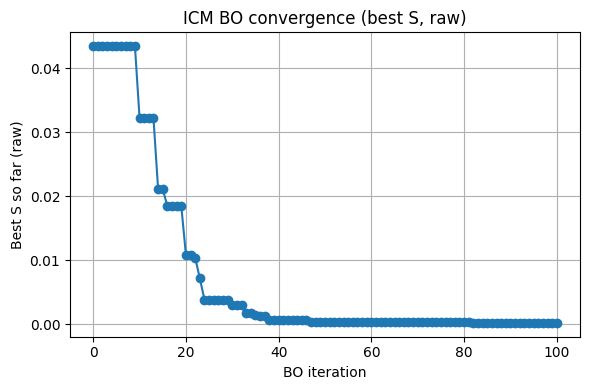

In [22]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(len(S_history_raw))

plt.figure(figsize=(6,4))
plt.plot(iters, S_history_raw, marker="o")
plt.xlabel("BO iteration")
plt.ylabel("Best S so far (raw)")
plt.title("ICM BO convergence (best S, raw)")
plt.grid(True)
plt.tight_layout()
plt.show()

Best OD index: 72
Best OD vector: [495.09137 532.0316  930.4046  879.07587]
GT OD vector:  [500. 500. 900. 900.]


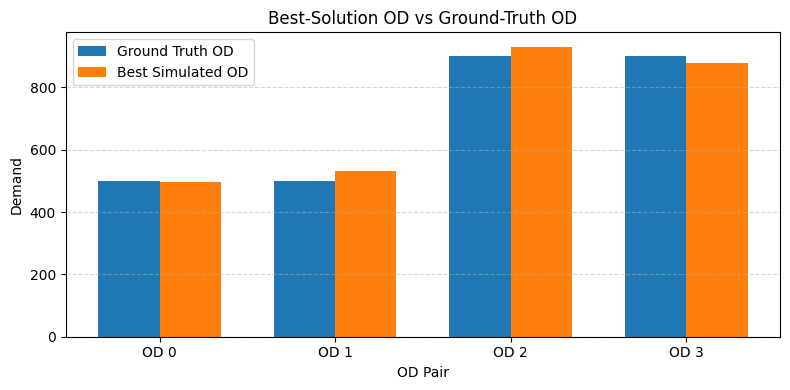

In [23]:
import numpy as np
import matplotlib.pyplot as plt


best_idx = int(np.argmin(S_obs_history_raw))
best_od = train_X_icm[best_idx].cpu().numpy() 

# Ground truth OD
gt_od = gt_od_df["count"].astype(float).values  

print("Best OD index:", best_idx)
print("Best OD vector:", best_od)
print("GT OD vector: ", gt_od)


labels = [f"OD {i}" for i in range(len(gt_od))]

x = np.arange(len(gt_od))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, gt_od,  width, label="Ground Truth OD")
plt.bar(x + width/2, best_od, width, label="Best Simulated OD")

plt.xlabel("OD Pair")
plt.ylabel("Demand")
plt.title("Best-Solution OD vs Ground-Truth OD")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
# Check the actual noise structure
likelihood = icm_model.likelihood
print(f"Likelihood type: {type(likelihood)}")
print(f"Likelihood num_tasks: {likelihood.num_tasks}")

# Check different noise attributes
print(f"\nNoise attributes:")
print(f"  noise: {likelihood.noise.shape if hasattr(likelihood.noise, 'shape') else 'scalar'}")
print(f"  noise.data: {likelihood.noise.data.shape if hasattr(likelihood.noise.data, 'shape') else 'scalar'}")

# Try accessing task-specific noise if it exists
if hasattr(likelihood, 'task_noises'):
    print(f"  task_noises: {likelihood.task_noises.shape if hasattr(likelihood.task_noises, 'shape') else 'N/A'}")
    print(f"  task_noises.data: {likelihood.task_noises.data}")

# List all attributes
print(f"\nAll likelihood attributes containing 'noise':")
for attr in dir(likelihood):
    if 'noise' in attr.lower():
        try:
            val = getattr(likelihood, attr)
            if not callable(val):
                print(f"  {attr}: {val}")
        except:
            pass

Likelihood type: <class 'gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood'>
Likelihood num_tasks: 14

Noise attributes:
  noise: torch.Size([1])
  noise.data: torch.Size([1])
  task_noises: torch.Size([14])
  task_noises.data: tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0001, 0.0002, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0002, 0.0001])

All likelihood attributes containing 'noise':
  has_global_noise: True
  has_task_noise: True
  noise: tensor([1.0000e-04], grad_fn=<AddBackward0>)
  raw_noise: Parameter containing:
tensor([-33.2101], requires_grad=True)
  raw_task_noises: Parameter containing:
tensor([-10.2099, -10.8823,  -9.9665, -11.4522, -10.0339,  -9.8044, -10.4997,
         -9.7462, -10.5938, -14.1344, -11.1305, -12.9105,  -9.4504, -13.1810],
       requires_grad=True)
  task_noises: tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0001, 0.0002, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0002, 0.0001], grad_fn=<AddBackward0>

In [25]:
# Check task-specific noise (this is what you want!)
task_noises = icm_model.likelihood.task_noises.data
num_tasks = len(task_noises)

print(f"Number of tasks (edges): {num_tasks}")
print(f"\nNoise per task:")
print("-" * 50)
for task_idx in range(num_tasks):
    noise_val = task_noises[task_idx].item()
    status = ""
    if abs(noise_val - 1e-4) < 1e-5:
        status = " LOWER LIMIT"
    elif abs(noise_val - 1.0) < 1e-5:
        status = "  UPPER LIMIT"
    print(f"  Task {task_idx:3d}: {noise_val:.6f}{status}")

print("-" * 50)
print(f"Summary: min={task_noises.min():.6f}, max={task_noises.max():.6f}, mean={task_noises.mean():.6f}")

# Check limits
lower_bound = 1e-4
upper_bound = 1.0
at_lower = (task_noises - lower_bound).abs() < 1e-5
at_upper = (task_noises - upper_bound).abs() < 1e-5

if at_lower.any():
    task_indices = torch.where(at_lower)[0].tolist()
    print(f"\n  {at_lower.sum()} task(s) at LOWER limit: tasks {task_indices}")
if at_upper.any():
    task_indices = torch.where(at_upper)[0].tolist()
    print(f"  {at_upper.sum()} task(s) at UPPER limit: tasks {task_indices}")

Number of tasks (edges): 14

Noise per task:
--------------------------------------------------
  Task   0: 0.000137
  Task   1: 0.000119
  Task   2: 0.000147
  Task   3: 0.000111
  Task   4: 0.000144
  Task   5: 0.000155
  Task   6: 0.000128
  Task   7: 0.000159
  Task   8: 0.000125
  Task   9: 0.000101 LOWER LIMIT
  Task  10: 0.000115
  Task  11: 0.000102 LOWER LIMIT
  Task  12: 0.000179
  Task  13: 0.000102 LOWER LIMIT
--------------------------------------------------
Summary: min=0.000101, max=0.000179, mean=0.000130

  3 task(s) at LOWER limit: tasks [9, 11, 13]


In [26]:
# B matrix (task covariance / coregionalization)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
print("B shape:", B.shape)
print(B)

B shape: torch.Size([14, 14])
tensor([[12.2939,  0.2879,  0.2693,  1.1504,  0.9957,  0.9945,  1.1512,  1.1501,
          0.9945,  0.2399,  0.1823,  0.2463,  0.4345,  0.3205],
        [ 0.2879, 12.6287,  0.2920,  1.1862,  1.1905,  1.1892,  1.1872,  1.1860,
          1.1892,  0.2547,  0.1987,  0.2719,  0.5362,  0.3242],
        [ 0.2693,  0.2920, 12.4815,  1.1476,  1.0416,  1.0403,  1.1485,  1.1474,
          1.0403,  0.2415,  0.1850,  0.2510,  0.4594,  0.3179],
        [ 1.1504,  1.1862,  1.1476,  7.8611, -1.1632, -1.1690,  7.8630,  7.8585,
         -1.1703,  1.2861,  0.7227,  0.8062, -1.3228,  2.4933],
        [ 0.9957,  1.1905,  1.0416, -1.1632, 14.1010, 14.0974, -1.1571, -1.1615,
         14.0990,  0.4277,  0.8069,  1.4131,  7.6989, -0.8994],
        [ 0.9945,  1.1892,  1.0403, -1.1690, 14.0974, 14.0941, -1.1629, -1.1673,
         14.0956,  0.4266,  0.8061,  1.4121,  7.6976, -0.9011],
        [ 1.1512,  1.1872,  1.1485,  7.8630, -1.1571, -1.1629,  7.8650,  7.8604,
         -1.1641,  

In [27]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])
print(corr)

tensor([[ 1.0000,  0.0231,  0.0217,  0.1170,  0.0756,  0.0756,  0.1171,  0.1170,
          0.0755,  0.0279,  0.0218,  0.0249,  0.0269,  0.0316],
        [ 0.0231,  1.0000,  0.0233,  0.1191,  0.0892,  0.0891,  0.1191,  0.1191,
          0.0891,  0.0292,  0.0234,  0.0272,  0.0328,  0.0316],
        [ 0.0217,  0.0233,  1.0000,  0.1159,  0.0785,  0.0784,  0.1159,  0.1159,
          0.0784,  0.0279,  0.0219,  0.0252,  0.0282,  0.0311],
        [ 0.1170,  0.1191,  0.1159,  1.0000, -0.1105, -0.1111,  1.0000,  1.0000,
         -0.1112,  0.1871,  0.1080,  0.1020, -0.1024,  0.3078],
        [ 0.0756,  0.0892,  0.0785, -0.1105,  1.0000,  1.0000, -0.1099, -0.1104,
          1.0000,  0.0464,  0.0901,  0.1336,  0.4451, -0.0829],
        [ 0.0756,  0.0891,  0.0784, -0.1111,  1.0000,  1.0000, -0.1104, -0.1109,
          1.0000,  0.0463,  0.0900,  0.1335,  0.4451, -0.0831],
        [ 0.1171,  0.1191,  0.1159,  1.0000, -0.1099, -0.1104,  1.0000,  1.0000,
         -0.1106,  0.1871,  0.1081,  0.1021, -0.1

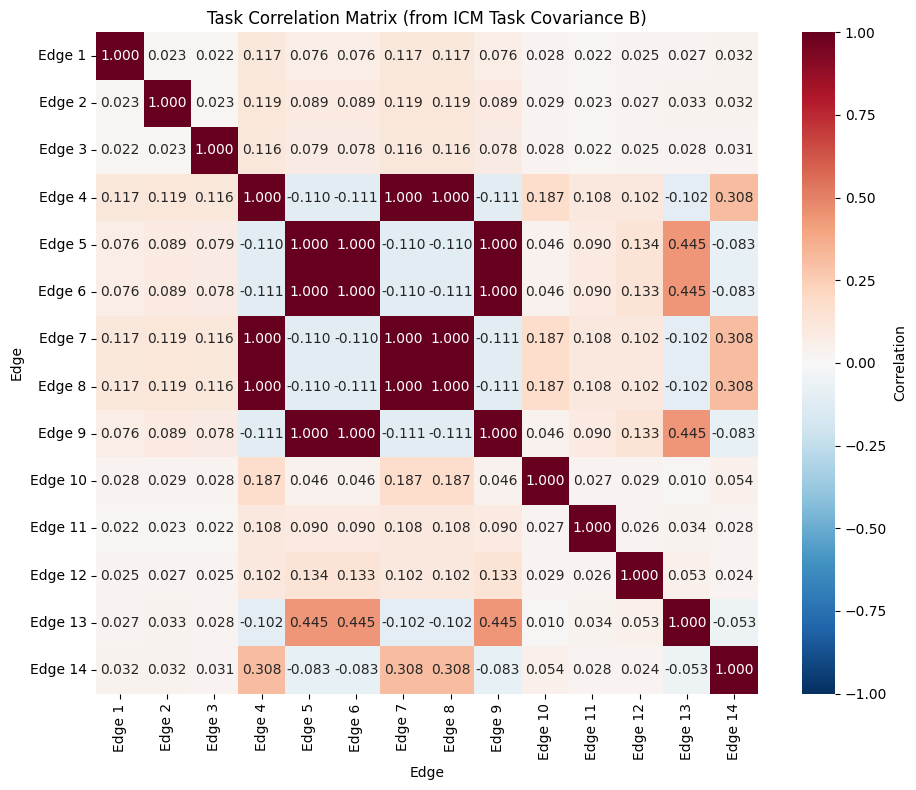

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Your existing code to compute correlation
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

# Convert to numpy for plotting
corr_np = corr.detach().cpu().numpy()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=[f'Edge {i+1}' for i in range(L)],
    yticklabels=[f'Edge {i+1}' for i in range(L)],
)
plt.title('Task Correlation Matrix (from ICM Task Covariance B)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.tight_layout()
plt.show()


In [29]:
edge_ids = gt_edge_data["edge_id"].tolist()

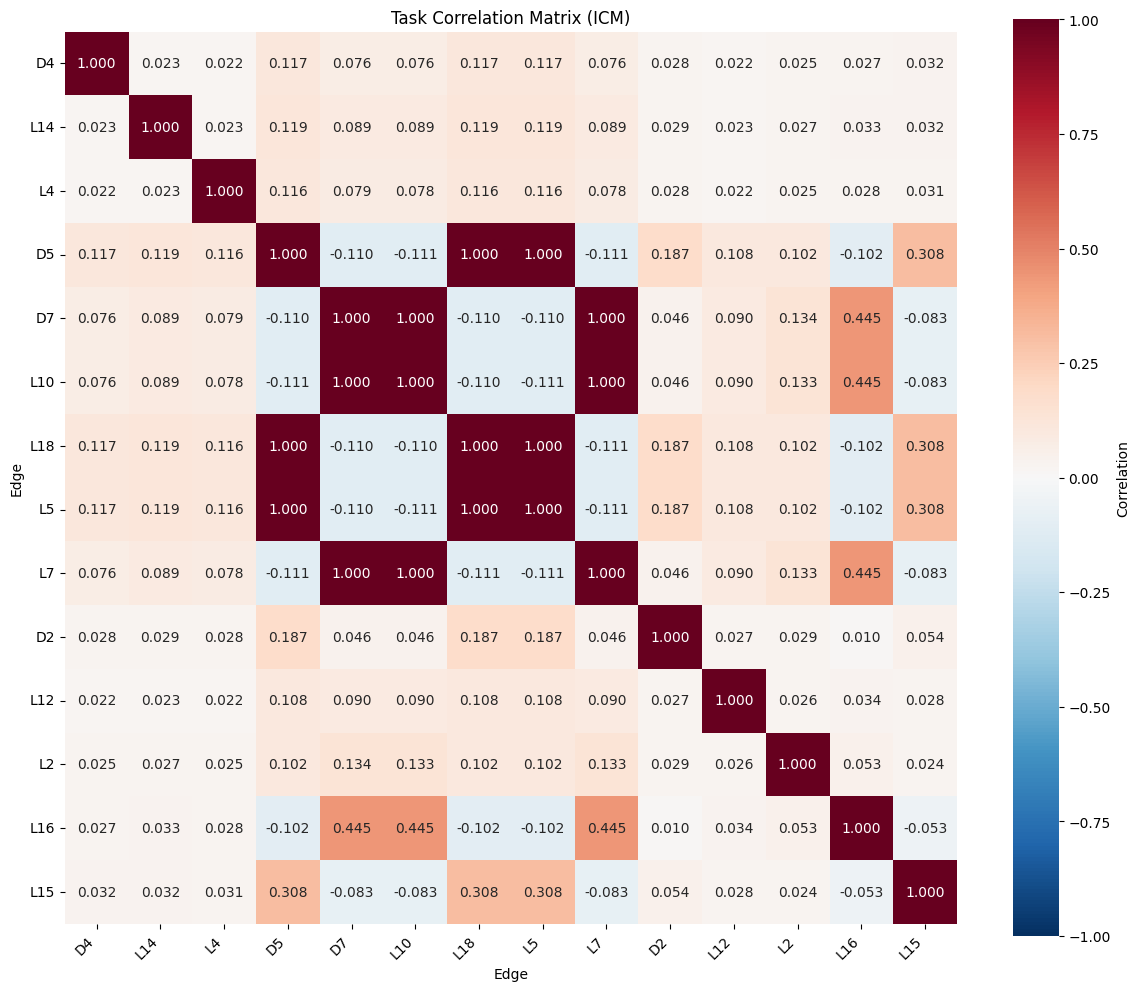

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Compute correlation (your existing code)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

corr_np = corr.detach().cpu().numpy()

# Create heatmap with edge IDs as labels
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=edge_ids,  # Use actual edge IDs
    yticklabels=edge_ids,
)
plt.title('Task Correlation Matrix (ICM)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.xticks(rotation=45, ha='right')  # Rotate labels if needed
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## comparing scalar gp with icm 

In [31]:
print(train_X_icm_init)

tensor([[1995.0267,  208.7328, 1645.9578,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3398],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2373],
        [ 208.3256, 1373.7338, 1810.7881,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4969],
        [1642.0144, 1849.8972, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8531, 1135.5953, 1953.6954],
        [  97.3469,   66.7411,  384.3306,  587.1246],
        [1006.2524, 1536.8247, 1885.7072, 1482.5537],
        [1357.3130,  396.7292, 1282.7886, 1120.7015],
        [ 257.9750, 1991.8317,  784.0896,  949.7550],
        [ 790.8787,  889.4018, 1532.9441, 1567.5588],
        [1824.3027, 1483.7563,   33.9629,  486.5554],
        [1770.7188,  937.5904, 1217.8479, 1300.8279],
        [ 860.3464, 1408.1616,  715.2431,  628.0270],
        [ 329.1326,  461.825

In [32]:
#same
print(train_X_icm_init[1])
print(train_X_icm[1])


tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])
tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])


In [33]:
"""
GP Hyperparameter Optimization Process:

1. ExactMarginalLogLikelihood (MLL):
   - Computes the marginal log-likelihood: log p(Y | X, θ)
   - Evaluates how well the model explains the data given current hyperparameters θ
   - Provides gradients for optimization
   
   Example:
       mll = ExactMarginalLogLikelihood(model.likelihood, model)
       current_mll = mll()  # log p(Y | X, θ_current)

2. fit_gpytorch_mll:
   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)
   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)
   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)
   
   Example:
       fit_gpytorch_mll(mll)  # Optimizes hyperparameters
       # After fitting, model has optimized θ*

Hyperparameters optimized:
   - Kernel: lengthscales ℓ, output variance σ²_f
   - Task covariance: matrix B (rank-1: parameters b)
   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]
   - Mean: per-task mean μ = [μ₁, ..., μ_L]
"""

'\nGP Hyperparameter Optimization Process:\n\n1. ExactMarginalLogLikelihood (MLL):\n   - Computes the marginal log-likelihood: log p(Y | X, θ)\n   - Evaluates how well the model explains the data given current hyperparameters θ\n   - Provides gradients for optimization\n\n   Example:\n       mll = ExactMarginalLogLikelihood(model.likelihood, model)\n       current_mll = mll()  # log p(Y | X, θ_current)\n\n2. fit_gpytorch_mll:\n   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)\n   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)\n   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)\n\n   Example:\n       fit_gpytorch_mll(mll)  # Optimizes hyperparameters\n       # After fitting, model has optimized θ*\n\nHyperparameters optimized:\n   - Kernel: lengthscales ℓ, output variance σ²_f\n   - Task covariance: matrix B (rank-1: parameters b)\n   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]\n   - Mean: per-task mean μ = [μ₁, ..., μ_L]\n'

In [34]:
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
import numpy as np
from src.models.gp_models import initialize_vanillabo_model
from src.utils.seed import set_seed

if "train_X_icm_init" not in locals():
    train_X_icm_init = train_X_icm.clone()
if "train_Y_icm_raw_init" not in locals():
    train_Y_icm_raw_init = train_Y_icm_raw.clone()

weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

vanilla_histories_raw = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"  {r+1}/{N_RESTARTS}")
    print("============================\n")

    ##
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")
    ###


    train_X_van = train_X_icm_init.clone()

    # Aggregate initial per-edge errors into a single scalar S for scalar gp ( vanilla bo ) target 
    train_Y_raw_van = (train_Y_icm_raw_init * weights_uniform).sum(dim=1) 

    S_raw_all = train_Y_raw_van 
    best_S_raw = S_raw_all.min().item()

    S_history_raw_van = [best_S_raw]
    S_obs_history_raw_van = S_raw_all.detach().cpu().tolist()

    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"    VANILLA BO ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")


        # Fit vanilla GP on aggregated S (outcome_transform handles standardization)
        train_X_norm_van = normalize(train_X_van, bounds=bounds)


        model = initialize_vanillabo_model(train_X_norm_van, S_raw_all.unsqueeze(-1), kernel="matern-2p5")
        # raw values as outcome trasnform handles standardization 
        



        #### fitting the gp : finding the best hyperparameters 
        mll = ExactMarginalLogLikelihood(model.likelihood, model) ## compute the marginal log likelihood 


        #fit_gpytorch_mll(mll)
        fit_gpytorch_mll_with_retries(  # maximize the marginal log likelihood with default optimizer L-BFGS-B
            mll,
            max_retries=3,
            base_jitter=1e-3,
            initial_jitter=0.0,
            jitter_multiplier=10.0,
            verbose=True,)

        model.eval() # making predictions



        ##### inference : compute the posterior mean and varaince at test points 
        EI = ExpectedImprovement(
            model=model, # EI call model.posterior internally, ExpectedImprovement is designed to work with a model that can compute posteriors at arbitrary points.
            best_f=best_S_raw,
            maximize=False,
        )

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )


        x_next_norm = x_next_norm.detach()

        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")

        # Run SUMO simulation for new od 
        sim_dir = f"{config['simulation_run_path']}/vanilla_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        # Compute aggregated loss 
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        curr_loss = compute_nrmse_counts_all_edges(
            gt_edge_data,
            curr_loop_stats,
        )
        S_next_raw = torch.tensor(curr_loss, device=device, dtype=dtype)

    
        S_obs_history_raw_van.append(S_next_raw.item())
        if S_next_raw.item() < best_S_raw:
            best_S_raw = S_next_raw.item()

        S_history_raw_van.append(best_S_raw)

        # Update training data
        train_X_van = torch.cat(
            [train_X_van, torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_raw_van = torch.cat(
            [train_Y_raw_van, S_next_raw.view(1)],
            dim=0,
        )
        S_raw_all = train_Y_raw_van

    vanilla_histories_raw.append(S_history_raw_van)

# Mean curve across restarts (raw)
min_len = min(len(h) for h in vanilla_histories_raw)
S_history_raw_van = np.mean([h[:min_len] for h in vanilla_histories_raw], axis=0).tolist()

print("\nFinished Vanilla BO.")
print(f"Final best S (raw, mean) = {S_history_raw_van[-1]:.6f}")




  1/3

[SEED] Set seed to 42 for restart 1


    VANILLA BO ITER 1/100

ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.26927277 0.42764223 0.         0.        ]]
[ACQ] Candidate OD (real space) = [538.54553 855.2844    0.        0.     ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.3095684  0.21423894 0.42333782 0.46505037]]
[ACQ] Candidate OD (real space) = [619.13684 428.47787 846.67566 930.10077]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.36588693 0.05482345 0.41777003 0.46913108]]
[ACQ] Candidate OD (real space) = [731.77386  109.646904 835.54004  938.26215 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22023495 0.3198138  0.49850756 0.42011252]]
[ACQ] Candidate OD (real space) = [440.46988 639.62756 997.01514 840.22504]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.         0.46414608 0.70653784 0.26578853]]
[ACQ] Candidate OD (real space) = [   0.      928.2922 1413.0757  531.577 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22924283 0.27571246 0.55438673 0.43044353]]
[ACQ] Candidate OD (real space) = [ 458.48566  551.4249  1108.7734   860.887  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_trips

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=c

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[ACQ] x_next_norm = [[0.10437179 0.229979   0.41124716 0.61081994]]
[ACQ] Candidate OD (real space) = [ 208.74359  459.95798  822.4943  1221.6399 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validat

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (1ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.54
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3107716  0.0623487  0.03886533 0.63253844]]
[ACQ] Candidate OD (real space) = [ 621.5432   124.6974    77.73066 1265.0769 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33292663 0.00317449 0.4400396  0.18633628]]
[ACQ] Candidate OD (real space) = [665.8533      6.3489842 880.0792    372.67255  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.14294976 0.44897267 0.5146481  0.36210704]]
[ACQ] Candidate OD (real space) = [ 285.8995   897.9454  1029.2961   724.21405]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2989982 0.2277477 0.4790993 0.3813766]]
[ACQ] Candidate OD (real space) = [597.9964 455.4954 958.1986 762.7532]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_res

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.734288   0.01033207 0.06523938 0.6545979 ]]
[ACQ] Candidate OD (real space) = [1468.5759     20.664146  130.47878  1309.1958  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.5121758  0.03357353 0.13274051 0.21097843]]
[ACQ] Candidate OD (real space) = [1024.3516    67.14706  265.48102  421.95688]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17767824 0.25236002 0.53574646 0.37252298]]
[ACQ] Candidate OD (real space) = [ 355.35648  504.72003 1071.4929   745.04596]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19956157 0.37029508 0.44791073 0.4240645 ]]
[ACQ] Candidate OD (real space) = [399.12314 740.59015 895.8215  848.12897]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.08740632 0.96157557 0.03520899 0.03670191]]
[ACQ] Candidate OD (real space) = [ 174.81264 1923.1511    70.41797   73.40383]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 298.99
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.40317786 0.21582136 0.16397718 0.34732753]]
[ACQ] Candidate OD (real space) = [806.3557  431.6427  327.95435 694.6551 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validat

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2950298  0.3782879  0.36236337 0.37777698]]
[ACQ] Candidate OD (real space) = [590.0596  756.5758  724.72675 755.55396]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29030162 0.26967672 0.3618059  0.4309269 ]]
[ACQ] Candidate OD (real space) = [580.6033  539.35345 723.61176 861.85376]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00998713 0.67149335 0.8899078  0.7711617 ]]
[ACQ] Candidate OD (real space) = [  19.974264 1342.9867   1779.8156   1542.3234  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.8642705  0.31573007 0.40117905 0.2205921 ]]
[ACQ] Candidate OD (real space) = [1728.541    631.46014  802.3581   441.1842 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09113321 0.42814466 0.6750535  0.4222038 ]]
[ACQ] Candidate OD (real space) = [ 182.26642  856.2893  1350.1069   844.4076 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2249582  0.21563293 0.38805395 0.5194146 ]]
[ACQ] Candidate OD (real space) = [ 449.91638  431.26587  776.1079  1038.8292 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.90188134 0.37453145 0.3672293  0.57654756]]
[ACQ] Candidate OD (real space) = [1803.7627   749.06287  734.4586  1153.0951 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.71826154 0.44516602 0.4084898  0.737452  ]]
[ACQ] Candidate OD (real space) = [1436.5231   890.33203  816.9796  1474.9039 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17962332 0.32020167 0.441066   0.43056554]]
[ACQ] Candidate OD (real space) = [359.24664 640.4033  882.132   861.13104]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.23534961 0.5363521  0.38779905 0.516118  ]]
[ACQ] Candidate OD (real space) = [ 470.69922 1072.7042   775.5981  1032.236  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18571018 0.27174947 0.48366717 0.5054955 ]]
[ACQ] Candidate OD (real space) = [ 371.42035  543.49896  967.33435 1010.99097]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.45077986 0.01941467 0.01781992 0.94192606]]
[ACQ] Candidate OD (real space) = [ 901.5597     38.829334   35.63984  1883.8522  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.907129   0.6544561  0.6539813  0.42554253]]
[ACQ] Candidate OD (real space) = [1814.2579 1308.9121 1307.9626  851.0851]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.26265404 0.19773746 0.93607503 0.8546108 ]]
[ACQ] Candidate OD (real space) = [ 525.30804  395.4749  1872.15    1709.2216 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7051038  0.29000407 0.20770486 0.57864326]]
[ACQ] Candidate OD (real space) = [1410.2076   580.0082   415.40973 1157.2865 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28474924 0.704933   0.75013536 0.25466654]]
[ACQ] Candidate OD (real space) = [ 569.4985  1409.866   1500.2708   509.33307]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25677487 0.1680119  0.51329863 0.48245656]]
[ACQ] Candidate OD (real space) = [ 513.54974  336.0238  1026.5973   964.91315]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7379134  0.5552177  0.20930052 0.34556636]]
[ACQ] Candidate OD (real space) = [1475.8269  1110.4354   418.60104  691.13275]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.250318   0.20632148 0.47330734 0.38361612]]
[ACQ] Candidate OD (real space) = [500.636   412.64294 946.6147  767.23224]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 298.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35438257 0.6549612  0.09545647 0.595575  ]]
[ACQ] Candidate OD (real space) = [ 708.76514 1309.9225   190.91295 1191.1499 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28754988 0.19809595 0.5097945  0.50123936]]
[ACQ] Candidate OD (real space) = [ 575.0998  396.1919 1019.5889 1002.4787]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01601761 0.52734464 0.18541232 0.16023555]]
[ACQ] Candidate OD (real space) = [  32.035217 1054.6893    370.82465   320.4711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.22391686 0.02895422 0.44879463 0.9547542 ]]
[ACQ] Candidate OD (real space) = [ 447.8337     57.908447  897.5893   1909.5083  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.26376542 0.3911935  0.56405264 0.33976617]]
[ACQ] Candidate OD (real space) = [ 527.5308   782.387   1128.1052   679.53235]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33609706 0.21711257 0.42617282 0.4139412 ]]
[ACQ] Candidate OD (real space) = [672.19415 434.22513 852.34564 827.8824 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.37514913 0.64483184 0.294887   0.7944211 ]]
[ACQ] Candidate OD (real space) = [ 750.2983 1289.6637  589.774  1588.8422]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.94819504 0.16611302 0.2490771  0.9139722 ]]
[ACQ] Candidate OD (real space) = [1896.3901   332.22604  498.1542  1827.9445 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35900423 0.0956488  0.25083625 0.5200025 ]]
[ACQ] Candidate OD (real space) = [ 718.0085   191.2976   501.67252 1040.005  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.2692736  0.05281329 0.33501935 0.6039578 ]]
[ACQ] Candidate OD (real space) = [ 538.54724  105.62659  670.0387  1207.9155 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.77107227 0.99408406 0.25785813 0.32359666]]
[ACQ] Candidate OD (real space) = [1542.1445  1988.1681   515.71625  647.1933 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 298.93
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01829889 0.69740814 0.5844007  0.41541123]]
[ACQ] Candidate OD (real space) = [  36.597775 1394.8163   1168.8014    830.82245 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.16245347 0.37531087 0.43694985 0.2458001 ]]
[ACQ] Candidate OD (real space) = [324.90695 750.62177 873.8997  491.6002 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5381972  0.37518212 0.74569774 0.5355592 ]]
[ACQ] Candidate OD (real space) = [1076.3944   750.36426 1491.3955  1071.1184 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28567076 0.2377349  0.3854788  0.39719248]]
[ACQ] Candidate OD (real space) = [571.3415  475.4698  770.9576  794.38495]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7835844  0.65505266 0.8738907  0.24458514]]
[ACQ] Candidate OD (real space) = [1567.1688 1310.1053 1747.7814  489.1703]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9062126  0.28910366 0.54645514 0.7567874 ]]
[ACQ] Candidate OD (real space) = [1812.4253   578.20734 1092.9103  1513.5748 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25618127 0.22165959 0.32002506 0.44041872]]
[ACQ] Candidate OD (real space) = [512.36255 443.31918 640.0501  880.83746]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.60809255 0.28180876 0.5177883  0.2186479 ]]
[ACQ] Candidate OD (real space) = [1216.185    563.61755 1035.5765   437.2958 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21195461 0.22060652 0.46419552 0.55849576]]
[ACQ] Candidate OD (real space) = [ 423.9092   441.21304  928.39105 1116.9916 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16856974 0.32989797 0.51160616 0.42747316]]
[ACQ] Candidate OD (real space) = [ 337.1395   659.79596 1023.21234  854.9463 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18173817 0.28517985 0.845913   0.9626927 ]]
[ACQ] Candidate OD (real space) = [ 363.47635  570.3597  1691.8259  1925.3854 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3368414  0.19208866 0.42804897 0.5007795 ]]
[ACQ] Candidate OD (real space) = [ 673.6828   384.17734  856.09796 1001.559  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00835887 0.02955176 0.31237707 0.7094255 ]]
[ACQ] Candidate OD (real space) = [  16.717731   59.103523  624.75415  1418.8511  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.26
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09448539 0.34869644 0.33753258 0.4680253 ]]
[ACQ] Candidate OD (real space) = [188.97078 697.3929  675.0652  936.0506 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.51558715 0.56973505 0.23881964 0.7001257 ]]
[ACQ] Candidate OD (real space) = [1031.1743  1139.4701   477.63928 1400.2513 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.5171855  0.03544465 0.7305676  0.16798943]]
[ACQ] Candidate OD (real space) = [1034.371     70.8893  1461.1351   335.97885]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16634762 0.30296922 0.6644406  0.3646403 ]]
[ACQ] Candidate OD (real space) = [ 332.69525  605.9384  1328.8811   729.2806 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.27073127 0.20153439 0.39408618 0.57987845]]
[ACQ] Candidate OD (real space) = [ 541.4625   403.0688   788.17236 1159.757  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33635253 0.25678185 0.33107626 0.60004807]]
[ACQ] Candidate OD (real space) = [ 672.7051  513.5637  662.1525 1200.0962]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.38605306 0.04383963 0.3472756  0.6202289 ]]
[ACQ] Candidate OD (real space) = [ 772.10614   87.67926  694.5512  1240.4578 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00206747 0.40793988 0.5938441  0.6209141 ]]
[ACQ] Candidate OD (real space) = [   4.1349473  815.87976   1187.6882    1241.8282   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.00586286 0.8350357  0.95023835 0.0816812 ]]
[ACQ] Candidate OD (real space) = [  11.725713 1670.0714   1900.4767    163.3624  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17935027 0.37101147 0.5454151  0.36635378]]
[ACQ] Candidate OD (real space) = [ 358.70053  742.02295 1090.8302   732.7076 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03593468 0.9565298  0.04731014 0.92759484]]
[ACQ] Candidate OD (real space) = [  71.86937  1913.0596     94.620285 1855.1897  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02642471 0.74203265 0.4632082  0.06222977]]
[ACQ] Candidate OD (real space) = [  52.849426 1484.0653    926.4164    124.45953 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8769613  0.20943916 0.15045977 0.25111344]]
[ACQ] Candidate OD (real space) = [1753.9226   418.87833  300.91953  502.2269 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29367498 0.10971624 0.42144403 0.5782659 ]]
[ACQ] Candidate OD (real space) = [ 587.35     219.43248  842.88806 1156.5319 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9722222  0.31039953 0.5830242  0.11370039]]
[ACQ] Candidate OD (real space) = [1944.4445   620.7991  1166.0485   227.40079]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.31996453 0.23313428 0.53425306 0.6190383 ]]
[ACQ] Candidate OD (real space) = [ 639.9291   466.26855 1068.5061  1238.0765 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6998856  0.7829651  0.51594794 0.27802604]]
[ACQ] Candidate OD (real space) = [1399.7712  1565.9303  1031.8959   556.05206]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6153376  0.6029495  0.86328423 0.18557456]]
[ACQ] Candidate OD (real space) = [1230.6752 1205.899  1726.5685  371.1491]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

[ACQ] x_next_norm = [[0.26915252 0.42717645 0.         0.        ]]
[ACQ] Candidate OD (real space) = [538.30505 854.3529    0.        0.     ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.3092274  0.21516284 0.42379943 0.4643535 ]]
[ACQ] Candidate OD (real space) = [618.45483 430.32568 847.5989  928.70703]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.36496088 0.06027656 0.4180395  0.46946546]]
[ACQ] Candidate OD (real space) = [729.92175  120.553116 836.079    938.9309  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.34265292 0.20215869 0.3214992  0.47778916]]
[ACQ] Candidate OD (real space) = [685.30585 404.31738 642.9984  955.5783 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22027513 0.32173797 0.49166116 0.41812775]]
[ACQ] Candidate OD (real space) = [440.55026 643.47595 983.3223  836.2555 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.         0.46480602 0.70165503 0.25517747]]
[ACQ] Candidate OD (real space) = [   0.       929.61206 1403.31     510.35495]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.18186095 0.07195166 0.8360633  0.03448691]]
[ACQ] Candidate OD (real space) = [ 363.7219   143.90334 1672.1267    68.97382]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=c

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[ACQ] x_next_norm = [[0.26064306 0.27396137 0.46693003 0.445611  ]]
[ACQ] Candidate OD (real space) = [521.28613 547.9227  933.86005 891.222  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.3851855  0.04051441 0.05478947 0.6204009 ]]
[ACQ] Candidate OD (real space) = [ 770.37103   81.02881  109.57894 1240.8018 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0603756  0.5881501  0.1715742  0.12810056]]
[ACQ] Candidate OD (real space) = [ 120.7512 1176.3002  343.1484  256.2011]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21430431 0.51764697 0.47619885 0.08785181]]
[ACQ] Candidate OD (real space) = [ 428.6086  1035.294    952.3977   175.70363]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 298.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3708929  0.03963912 0.71438247 0.4301583 ]]
[ACQ] Candidate OD (real space) = [ 741.7858     79.278244 1428.7649    860.3166  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2260392  0.28068945 0.0677515  0.9155739 ]]
[ACQ] Candidate OD (real space) = [ 452.0784   561.3789   135.50299 1831.1478 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21712345 0.27370027 0.73488146 0.55134994]]
[ACQ] Candidate OD (real space) = [ 434.2469  547.4005 1469.763  1102.6998]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.13696992 0.99501574 0.47897106 0.09575114]]
[ACQ] Candidate OD (real space) = [ 273.93985 1990.0315   957.94214  191.50227]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.11231761 0.4930635  0.55765575 0.26550582]]
[ACQ] Candidate OD (real space) = [ 224.63521  986.127   1115.3115   531.01166]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.13592209 0.3611558  0.07674518 0.5573126 ]]
[ACQ] Candidate OD (real space) = [ 271.84418  722.31165  153.49037 1114.6252 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18704608 0.08288925 0.56391144 0.6644816 ]]
[ACQ] Candidate OD (real space) = [ 374.09216  165.7785  1127.8229  1328.9631 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6013411  0.03287814 0.36941308 0.9240423 ]]
[ACQ] Candidate OD (real space) = [1202.6823    65.75628  738.8262  1848.0846 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29830688 0.05114356 0.24729271 0.5524933 ]]
[ACQ] Candidate OD (real space) = [ 596.6138   102.28712  494.58542 1104.9866 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2299 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.48s
 Real time factor: 120502
 UPS: 2145997.907950
Vehicles:
 Inserted: 2299
 Running: 0
 Waiting: 0
Statistics (avg of 2299):
 RouteLength: 4694.82
 Speed: 10.56
 Duration: 446.19
 WaitingTime: 0.31
 TimeLoss: 103.32
 DepartDelay: 584.20
DijkstraRouter answered 4416 queries and explored 11.84 edges on average.
Di

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.14257246 0.2916449  0.4479231  0.4654125 ]]
[ACQ] Candidate OD (real space) = [285.14493 583.2898  895.8462  930.825  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.31554085 0.19798847 0.34239098 0.58170056]]
[ACQ] Candidate OD (real space) = [ 631.0817   395.97693  684.782   1163.4011 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.07012044 0.48113623 0.7057324  0.39310503]]
[ACQ] Candidate OD (real space) = [ 140.24088  962.27246 1411.4648   786.2101 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.00629476 0.77057314 0.43335414 0.47553405]]
[ACQ] Candidate OD (real space) = [  12.5895195 1541.1462     866.70825    951.0681   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/ne

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01668596 0.855424   0.9788559  0.25430712]]
[ACQ] Candidate OD (real space) = [  33.37192 1710.848   1957.7118   508.61423]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3720008  0.27003047 0.4224545  0.43811896]]
[ACQ] Candidate OD (real space) = [744.00165 540.0609  844.909   876.2379 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.49422786 0.01280881 0.09794652 0.11108717]]
[ACQ] Candidate OD (real space) = [988.4557   25.61762 195.89305 222.17435]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 298.94
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6226486  0.8664294  0.8387138  0.40631694]]
[ACQ] Candidate OD (real space) = [1245.2972  1732.8588  1677.4276   812.63385]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28580844 0.24736544 0.59255904 0.39029047]]
[ACQ] Candidate OD (real space) = [ 571.6169   494.7309  1185.118    780.58093]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24259141 0.21748541 0.4180949  0.3508836 ]]
[ACQ] Candidate OD (real space) = [485.18283 434.97083 836.1898  701.7672 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.36
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2953076  0.24062297 0.49932924 0.43585593]]
[ACQ] Candidate OD (real space) = [590.61523 481.24594 998.6585  871.71185]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24945107 0.32218134 0.49950987 0.47889727]]
[ACQ] Candidate OD (real space) = [498.90213 644.3627  999.0197  957.79456]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.36553907 0.19732493 0.38064888 0.46392292]]
[ACQ] Candidate OD (real space) = [731.0781  394.64987 761.2978  927.8458 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18904695 0.01709545 0.17868312 0.92842424]]
[ACQ] Candidate OD (real space) = [ 378.0939     34.190907  357.36624  1856.8485  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6505009  0.27624097 0.63852596 0.723508  ]]
[ACQ] Candidate OD (real space) = [1301.0018   552.48193 1277.0519  1447.016  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.65
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25294384 0.36857325 0.36240214 0.30557713]]
[ACQ] Candidate OD (real space) = [505.8877  737.1465  724.80426 611.15424]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21597604 0.20808601 0.4141669  0.39882472]]
[ACQ] Candidate OD (real space) = [431.9521  416.17203 828.3338  797.6494 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.93241566 0.72982115 0.3008837  0.43340078]]
[ACQ] Candidate OD (real space) = [1864.8313 1459.6423  601.7674  866.8016]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16589275 0.39553946 0.74754286 0.3301366 ]]
[ACQ] Candidate OD (real space) = [ 331.7855  791.0789 1495.0857  660.2732]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19834644 0.34325528 0.44574887 0.34822118]]
[ACQ] Candidate OD (real space) = [396.69287 686.51056 891.49774 696.4424 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2258755  0.26803303 0.41628557 0.3654649 ]]
[ACQ] Candidate OD (real space) = [451.751   536.06604 832.57117 730.9298 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.577516   0.03397502 0.9932104  0.05586861]]
[ACQ] Candidate OD (real space) = [1155.032     67.95004 1986.4208   111.73723]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6611525 0.3401653 0.7471325 0.8074384]]
[ACQ] Candidate OD (real space) = [1322.3049   680.33057 1494.265   1614.8767 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3616859  0.00724772 0.00314623 0.8866129 ]]
[ACQ] Candidate OD (real space) = [ 723.3718      14.495441     6.2924547 1773.2258   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16568351 0.22494914 0.5229231  0.49512112]]
[ACQ] Candidate OD (real space) = [ 331.367    449.8983  1045.8462   990.24225]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.38709202 0.048508   0.5114908  0.6735883 ]]
[ACQ] Candidate OD (real space) = [ 774.184     97.01601 1022.9816  1347.1765 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.27491105 0.20251237 0.50165445 0.46653458]]
[ACQ] Candidate OD (real space) = [ 549.8221   405.02475 1003.3089   933.06915]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.52
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25946903 0.37670264 0.53261954 0.32484895]]
[ACQ] Candidate OD (real space) = [ 518.93805  753.4053  1065.239    649.6979 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.06346633 0.7558399  0.03368598 0.96348   ]]
[ACQ] Candidate OD (real space) = [ 126.93265 1511.6798    67.37196 1926.96   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2910788  0.13757725 0.53814656 0.5370689 ]]
[ACQ] Candidate OD (real space) = [ 582.1576  275.1545 1076.2931 1074.1378]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3008 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.75s
 Real time factor: 76902.5
 UPS: 1689548.731642
Vehicles:
 Inserted: 3008
 Running: 0
 Waiting: 0
Statistics (avg of 3008):
 RouteLength: 4509.33
 Speed: 10.74
 Duration: 420.70
 WaitingTime: 0.34
 TimeLoss: 91.03
 DepartDelay: 843.10
DijkstraRouter answered 5845 queries and explored 11.13 edges on average.
Di

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3050802  0.19794752 0.483289   0.44569138]]
[ACQ] Candidate OD (real space) = [610.1604  395.89502 966.578   891.38275]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01202661 0.66353637 0.7140228  0.14557718]]
[ACQ] Candidate OD (real space) = [  24.05322 1327.0728  1428.0457   291.15436]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8098605  0.6044343  0.20821542 0.64829826]]
[ACQ] Candidate OD (real space) = [1619.7211  1208.8687   416.43082 1296.5966 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.54
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24605516 0.23047684 0.2712669  0.45027438]]
[ACQ] Candidate OD (real space) = [492.11032 460.95367 542.5338  900.54877]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.23729281 0.26191854 0.57029593 0.38088027]]
[ACQ] Candidate OD (real space) = [ 474.58563  523.8371  1140.5919   761.76056]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.523912   0.00119133 0.41503268 0.5063163 ]]
[ACQ] Candidate OD (real space) = [1047.824        2.3826678  830.06537   1012.6326   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01573486 0.9469316  0.967434   0.07254286]]
[ACQ] Candidate OD (real space) = [  31.469717 1893.8632   1934.8679    145.08572 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30307043 0.20723598 0.34385547 0.52408284]]
[ACQ] Candidate OD (real space) = [ 606.14087  414.47195  687.71094 1048.1656 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.26


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.871292   0.44156015 0.16108873 0.38038385]]
[ACQ] Candidate OD (real space) = [1742.584    883.1203   322.17746  760.7677 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.45915616 0.21422817 0.04916195 0.35390875]]
[ACQ] Candidate OD (real space) = [918.3123   428.45633   98.323906 707.8175  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.36
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.04420409 0.94309086 0.1650119  0.00584448]]
[ACQ] Candidate OD (real space) = [  88.40819  1886.1818    330.0238     11.688965]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9378229  0.34810805 0.8308856  0.5931432 ]]
[ACQ] Candidate OD (real space) = [1875.6458  696.2161 1661.7711 1186.2865]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30602875 0.1457862  0.38133904 0.48398277]]
[ACQ] Candidate OD (real space) = [612.0575 291.5724 762.6781 967.9655]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.1437594  0.28859594 0.5987163  0.4504426 ]]
[ACQ] Candidate OD (real space) = [ 287.5188   577.1919  1197.4326   900.88525]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24674585 0.19125433 0.3890564  0.5470522 ]]
[ACQ] Candidate OD (real space) = [ 493.4917   382.50867  778.11285 1094.1044 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.31
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30323792 0.34168667 0.31982535 0.47220215]]
[ACQ] Candidate OD (real space) = [606.4758  683.37335 639.6507  944.4043 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21793525 0.28977123 0.48201454 0.36369985]]
[ACQ] Candidate OD (real space) = [435.87048 579.5425  964.02905 727.3997 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03830541 0.35321903 0.30953747 0.03118758]]
[ACQ] Candidate OD (real space) = [ 76.61081  706.43805  619.07495   62.375156]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 298.94
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.833895   0.69353896 0.5422229  0.4591562 ]]
[ACQ] Candidate OD (real space) = [1667.79   1387.0779 1084.4458  918.3124]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.31
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19185115 0.6219644  0.27104896 0.8201404 ]]
[ACQ] Candidate OD (real space) = [ 383.7023 1243.9288  542.0979 1640.2809]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 298.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_82/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29279175 0.25453115 0.4504853  0.40196723]]
[ACQ] Candidate OD (real space) = [585.5835  509.0623  900.9706  803.93445]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2953448  0.00255814 0.3610575  0.46008554]]
[ACQ] Candidate OD (real space) = [590.6896     5.116284 722.115    920.1711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0015868  0.73392004 0.7986838  0.6818149 ]]
[ACQ] Candidate OD (real space) = [   3.1735952 1467.8401    1597.3677    1363.6298   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30921063 0.09882496 0.41045138 0.6883849 ]]
[ACQ] Candidate OD (real space) = [ 618.42126  197.64993  820.9028  1376.7698 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19724697 0.13957508 0.24304473 0.64133584]]
[ACQ] Candidate OD (real space) = [ 394.49393  279.15015  486.08948 1282.6716 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29518723 0.2769768  0.4180248  0.40224832]]
[ACQ] Candidate OD (real space) = [590.37445 553.9536  836.0496  804.49664]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25051042 0.24744768 0.44551063 0.45259088]]
[ACQ] Candidate OD (real space) = [501.02084 494.89536 891.02124 905.18176]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0094454  0.87248844 0.8518957  0.15994154]]
[ACQ] Candidate OD (real space) = [  18.890797 1744.9769   1703.7914    319.8831  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2487146  0.45040733 0.15467365 0.40600315]]
[ACQ] Candidate OD (real space) = [497.4292  900.81464 309.3473  812.0063 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35633206 0.57803154 0.9165281  0.02881446]]
[ACQ] Candidate OD (real space) = [ 712.6641  1156.0631  1833.0562    57.62893]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptima

Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_93/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.04564418 0.30788204 0.9556486  0.51658803]]
[ACQ] Candidate OD (real space) = [  91.28836  615.7641  1911.2972  1033.176  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09380534 0.6819654  0.8783502  0.10578696]]
[ACQ] Candidate OD (real space) = [ 187.61069 1363.9308  1756.7004   211.57393]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17729476 0.2583576  0.4778675  0.45142916]]
[ACQ] Candidate OD (real space) = [354.5895  516.7152  955.73505 902.85834]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3056736  0.20105505 0.74914306 0.2612308 ]]
[ACQ] Candidate OD (real space) = [ 611.34717  402.1101  1498.2861   522.4616 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

[ACQ] x_next_norm = [[0.26973268 0.4266245  0.         0.        ]]
[ACQ] Candidate OD (real space) = [539.4654 853.249    0.       0.    ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/sim_trips.xml -b 0 -e 57600 --additi

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.30986407 0.21368533 0.42347282 0.46452716]]
[ACQ] Candidate OD (real space) = [619.72815 427.37067 846.9456  929.0543 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.36776662 0.04825575 0.4193007  0.4692138 ]]
[ACQ] Candidate OD (real space) = [735.53326  96.51149 838.60144 938.4276 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22111648 0.3190074  0.4960115  0.42149568]]
[ACQ] Candidate OD (real space) = [442.23297 638.0148  992.023   842.99133]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.25759673 0.24646558 0.483643   0.46715662]]
[ACQ] Candidate OD (real space) = [515.1935  492.93115 967.286   934.31323]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.52
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation n

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.         0.46786985 0.6929054  0.26588553]]
[ACQ] Candidate OD (real space) = [   0.       935.7397  1385.8108   531.77106]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


[ACQ] x_next_norm = [[0.15372166 0.4173317  0.51442915 0.25906205]]
[ACQ] Candidate OD (real space) = [ 307.44333  834.6634  1028.8583   518.1241 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.01084142 0.28267008 0.24919623 0.51034886]]
[ACQ] Candidate OD (real space) = [  21.682835  565.34015   498.39246  1020.6977  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/sim_trips.xml -b 0 -e 57

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.42068863 0.08014742 0.27855217 0.8636351 ]]
[ACQ] Candidate OD (real space) = [ 841.37726  160.29485  557.1044  1727.2703 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.21572827 0.362519   0.40718308 0.4348469 ]]
[ACQ] Candidate OD (real space) = [431.45654 725.03796 814.36615 869.6938 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.01261232 0.5693109  0.87290895 0.61729956]]
[ACQ] Candidate OD (real space) = [  25.224644 1138.6218   1745.8179   1234.5991  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.05770361 0.33117566 0.9761065  0.35634255]]
[ACQ] Candidate OD (real space) = [ 115.40723  662.3513  1952.213    712.6851 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0115121  0.50306267 0.59421873 0.03907407]]
[ACQ] Candidate OD (real space) = [  23.0242  1006.1253  1188.4375    78.14813]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02215493 0.6126125  0.48323485 0.40431884]]
[ACQ] Candidate OD (real space) = [  44.30986 1225.225    966.4697   808.6377 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validat

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.3819773  0.00113383 0.05866589 0.1815634 ]]
[ACQ] Candidate OD (real space) = [763.9546      2.2676532 117.33177   363.1268   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18138438 0.69085294 0.4571492  0.0809281 ]]
[ACQ] Candidate OD (real space) = [ 362.76877 1381.7059   914.2984   161.8562 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.32401484 0.3776454  0.5085913  0.09470921]]
[ACQ] Candidate OD (real space) = [ 648.02966  755.29083 1017.1826   189.41843]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02149215 0.9078939  0.07762411 0.08123926]]
[ACQ] Candidate OD (real space) = [  42.98429 1815.7878   155.24823  162.47852]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.02612446 0.9728505  0.94968927 0.00234221]]
[ACQ] Candidate OD (real space) = [  52.248924 1945.701    1899.3785      4.684411]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/sim_trips.xml -b 0 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2719298  0.2520509  0.28484133 0.5365324 ]]
[ACQ] Candidate OD (real space) = [ 543.8596  504.1018  569.6827 1073.0648]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17383593 0.48049167 0.6157698  0.40245548]]
[ACQ] Candidate OD (real space) = [ 347.67188  960.98334 1231.5396   804.91095]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 298.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01843887 0.30634904 0.2503028  0.25501904]]
[ACQ] Candidate OD (real space) = [ 36.87773 612.69806 500.6056  510.0381 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.412066   0.02635476 0.05138751 0.6289417 ]]
[ACQ] Candidate OD (real space) = [ 824.132      52.70951   102.775024 1257.8834  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.38729945 0.01451224 0.4934803  0.6413147 ]]
[ACQ] Candidate OD (real space) = [ 774.5989     29.024483  986.9606   1282.6294  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/sim_trips.xml -b 0 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20948492 0.30398738 0.4901102  0.48908168]]
[ACQ] Candidate OD (real space) = [418.96985 607.9748  980.2204  978.1634 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25606966 0.24540998 0.32366118 0.42186853]]
[ACQ] Candidate OD (real space) = [512.13934 490.81995 647.3223  843.73706]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2962969  0.21941102 0.5079635  0.4991137 ]]
[ACQ] Candidate OD (real space) = [ 592.5938   438.82202 1015.92694  998.2274 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03997432 0.6693724  0.06362792 0.96679634]]
[ACQ] Candidate OD (real space) = [  79.94863  1338.7448    127.255844 1933.5927  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.41886488 0.9016875  0.5062922  0.1584488 ]]
[ACQ] Candidate OD (real space) = [ 837.72974 1803.375   1012.5845   316.8976 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.3134713  0.6961521  0.22248434 0.07964214]]
[ACQ] Candidate OD (real space) = [ 626.94257 1392.3042   444.96866  159.28427]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.22846803 0.7304064  0.00268065 0.47329828]]
[ACQ] Candidate OD (real space) = [ 456.93607   1460.8129       5.3612905  946.59656  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.08737116 0.6350562  0.5535487  0.559143  ]]
[ACQ] Candidate OD (real space) = [ 174.74232 1270.1124  1107.0974  1118.286  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validat

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.27371287 0.22805999 0.4388262  0.5360324 ]]
[ACQ] Candidate OD (real space) = [ 547.4257  456.12    877.6524 1072.0647]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8679635  0.4175349  0.70362407 0.89023733]]
[ACQ] Candidate OD (real space) = [1735.927    835.06976 1407.2482  1780.4746 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21288954 0.23944335 0.35450754 0.45446584]]
[ACQ] Candidate OD (real space) = [425.77908 478.8867  709.0151  908.9317 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.995056   0.2885885  0.59874696 0.9308734 ]]
[ACQ] Candidate OD (real space) = [1990.1119  577.177  1197.4939 1861.7468]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.01465984 0.38967964 0.95777863 0.00617654]]
[ACQ] Candidate OD (real space) = [  29.319687  779.35925  1915.5573     12.353076]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/sim_trips.xml -b 0 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21381646 0.3442266  0.6131798  0.3680104 ]]
[ACQ] Candidate OD (real space) = [ 427.63293  688.4532  1226.3596   736.0208 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.53812766 0.10988177 0.6571631  0.579146  ]]
[ACQ] Candidate OD (real space) = [1076.2554   219.76355 1314.3262  1158.2921 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2327533  0.1511152  0.01398461 0.8402213 ]]
[ACQ] Candidate OD (real space) = [ 465.50662   302.23038    27.969227 1680.4426  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03922363 0.8274916  0.6577035  0.9554001 ]]
[ACQ] Candidate OD (real space) = [  78.44725 1654.9832  1315.407   1910.8002 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3018831  0.84972024 0.7935487  0.5769462 ]]
[ACQ] Candidate OD (real space) = [ 603.7662 1699.4404 1587.0974 1153.8925]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5887645  0.02022455 0.01133508 0.97835386]]
[ACQ] Candidate OD (real space) = [1177.5289     40.449097   22.67015  1956.7078  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.37742424 0.9036755  0.95101404 0.85379916]]
[ACQ] Candidate OD (real space) = [ 754.8485 1807.351  1902.0281 1707.5984]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.79471165 0.430191   0.10659634 0.39849374]]
[ACQ] Candidate OD (real space) = [1589.4233   860.382    213.19269  796.9875 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2285438  0.9835     0.03195296 0.6408261 ]]
[ACQ] Candidate OD (real space) = [ 457.08762 1967.        63.90592 1281.6522 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.51184374 0.1627477  0.97843903 0.43307966]]
[ACQ] Candidate OD (real space) = [1023.6875  325.4954 1956.878   866.1593]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03767815 0.99425566 0.06917185 0.9105153 ]]
[ACQ] Candidate OD (real space) = [  75.35631 1988.5114   138.34369 1821.0306 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.58019596 0.7854502  0.6575744  0.81583226]]
[ACQ] Candidate OD (real space) = [1160.392  1570.9004 1315.1488 1631.6646]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.88413763 0.09647217 0.7880045  0.9663255 ]]
[ACQ] Candidate OD (real space) = [1768.2753   192.94435 1576.009   1932.651  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.02517143 0.07302764 0.22987261 0.9008    ]]
[ACQ] Candidate OD (real space) = [  50.34285  146.05528  459.74524 1801.6    ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7717138  0.8393778  0.73547184 0.53529274]]
[ACQ] Candidate OD (real space) = [1543.4276 1678.7556 1470.9437 1070.5854]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24316351 0.2542031  0.45764625 0.43959945]]
[ACQ] Candidate OD (real space) = [486.32703 508.40622 915.2925  879.1989 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.11917301 0.03111492 0.47488526 0.653945  ]]
[ACQ] Candidate OD (real space) = [ 238.34601   62.22985  949.7705  1307.89   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.43773338 0.60134286 0.8355367  0.1890215 ]]
[ACQ] Candidate OD (real space) = [ 875.46674 1202.6857  1671.0735   378.043  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.20604976 0.20912571 0.45457703 0.41564015]]
[ACQ] Candidate OD (real space) = [412.09952 418.25143 909.15405 831.2803 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.35179394 0.24668801 0.33305353 0.45142356]]
[ACQ] Candidate OD (real space) = [703.5879  493.376   666.10706 902.8471 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 298.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8749585  0.511065   0.37739423 0.6036669 ]]
[ACQ] Candidate OD (real space) = [1749.917   1022.13     754.78845 1207.3339 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29168195 0.18761455 0.41627765 0.5355369 ]]
[ACQ] Candidate OD (real space) = [ 583.3639  375.2291  832.5553 1071.0737]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.4269913  0.12239159 0.54785705 0.9104275 ]]
[ACQ] Candidate OD (real space) = [ 853.9826   244.78317 1095.7141  1820.855  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.25516662 0.34080118 0.12475151 0.34521842]]
[ACQ] Candidate OD (real space) = [510.33325 681.60236 249.50302 690.4368 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8155446 0.5026774 0.9285305 0.281675 ]]
[ACQ] Candidate OD (real space) = [1631.0892  1005.35474 1857.061    563.35004]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 298.95
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21916948 0.24758148 0.21407866 0.95918304]]
[ACQ] Candidate OD (real space) = [ 438.33896  495.16296  428.15732 1918.3661 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29245824 0.21894431 0.36611852 0.96161246]]
[ACQ] Candidate OD (real space) = [ 584.91644  437.8886   732.23706 1923.225  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.60913295 0.29045668 0.36618125 0.34757954]]
[ACQ] Candidate OD (real space) = [1218.2659   580.9134   732.3625   695.15906]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3721586  0.2280728  0.5867501  0.41982356]]
[ACQ] Candidate OD (real space) = [ 744.3172  456.1456 1173.5001  839.6471]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5507193  0.01509819 0.08699018 0.14875677]]
[ACQ] Candidate OD (real space) = [1101.4386    30.19638  173.98036  297.51355]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09532987 0.29407465 0.00748578 0.6946031 ]]
[ACQ] Candidate OD (real space) = [ 190.65973   588.1493     14.971558 1389.2062  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9208993  0.51984745 0.17101908 0.35107586]]
[ACQ] Candidate OD (real space) = [1841.7986  1039.695    342.03815  702.15173]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 298.93
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.04406492 0.22036286 0.08790729 0.31509903]]
[ACQ] Candidate OD (real space) = [ 88.12984 440.7257  175.81459 630.19806]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.34135997 0.95498174 0.4037818  0.530838  ]]
[ACQ] Candidate OD (real space) = [ 682.72   1909.9635  807.5636 1061.676 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.4322214  0.02289329 0.17372835 0.71823555]]
[ACQ] Candidate OD (real space) = [ 864.4428     45.786583  347.4567   1436.4711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28853816 0.17056058 0.47529444 0.40167287]]
[ACQ] Candidate OD (real space) = [577.0763  341.12115 950.58887 803.34576]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8525245 0.7227018 0.78747   0.9027595]]
[ACQ] Candidate OD (real space) = [1705.0491 1445.4036 1574.94   1805.519 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6486192  0.83461833 0.08562286 0.00842471]]
[ACQ] Candidate OD (real space) = [1297.2384   1669.2367    171.24573    16.849415]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19137189 0.27836984 0.5101734  0.5577662 ]]
[ACQ] Candidate OD (real space) = [ 382.74377  556.7397  1020.34674 1115.5323 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3452298  0.3640743  0.40490687 0.9411951 ]]
[ACQ] Candidate OD (real space) = [ 690.4596   728.14856  809.8137  1882.3901 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7010398  0.49586305 0.26895726 0.44854507]]
[ACQ] Candidate OD (real space) = [1402.0796   991.7261   537.9145   897.09015]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7879525  0.36097893 0.79704976 0.61374265]]
[ACQ] Candidate OD (real space) = [1575.9049  721.9579 1594.0995 1227.4854]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16527627 0.9600447  0.05338223 0.83931625]]
[ACQ] Candidate OD (real space) = [ 330.55255 1920.0894   106.76445 1678.6324 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.07738678 0.39804322 0.40055105 0.89974517]]
[ACQ] Candidate OD (real space) = [ 154.77356  796.0864   801.1021  1799.4904 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20994613 0.3833984  0.5214364  0.33874977]]
[ACQ] Candidate OD (real space) = [ 419.89224  766.7968  1042.8728   677.4995 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7446101  0.95555085 0.74627185 0.9580677 ]]
[ACQ] Candidate OD (real space) = [1489.2201 1911.1017 1492.5437 1916.1354]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33516985 0.15901133 0.33322674 0.47132096]]
[ACQ] Candidate OD (real space) = [670.3397  318.02267 666.4535  942.6419 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20432906 0.3036166  0.46176296 0.36160892]]
[ACQ] Candidate OD (real space) = [408.6581  607.2332  923.52594 723.21783]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09983984 0.20952651 0.6366563  0.65299696]]
[ACQ] Candidate OD (real space) = [ 199.67969  419.053   1273.3126  1305.9939 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

# convergence curve

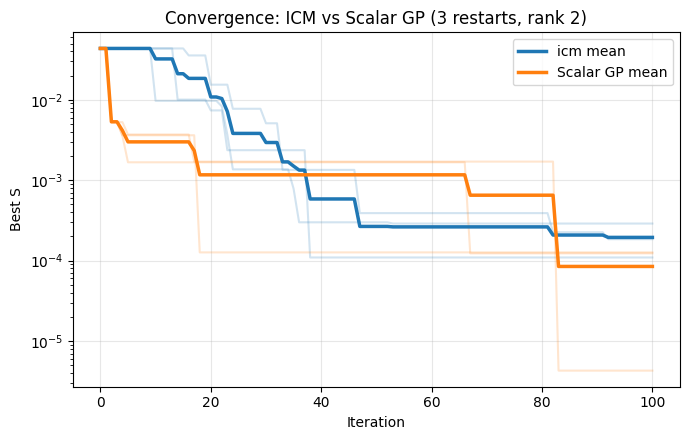

In [37]:

import matplotlib.pyplot as plt
import numpy as np


min_len = min(
    min(len(h) for h in icm_histories_raw),
    min(len(h) for h in vanilla_histories_raw),
)

xs = np.arange(min_len)

plt.figure(figsize=(7,4.5))


for h in icm_histories_raw:
    plt.plot(xs, np.array(h[:min_len]), color="tab:blue", alpha=0.2)

for h in vanilla_histories_raw:
    plt.plot(xs, np.array(h[:min_len]), color="tab:orange", alpha=0.2)

# Plot means (bold)
icm_mean = np.mean([h[:min_len] for h in icm_histories_raw], axis=0)
van_mean = np.mean([h[:min_len] for h in vanilla_histories_raw], axis=0)

plt.plot(xs, icm_mean, label="icm mean", color="tab:blue", linewidth=2.5)
plt.plot(xs, van_mean, label="Scalar GP mean", color="tab:orange", linewidth=2.5)



plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Best S")
plt.title("Convergence: ICM vs Scalar GP (3 restarts, rank 2)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
print("len(train_X_icm_init):", len(train_X_icm_init))
print("len(train_X_icm):", len(train_X_icm))
print("best raw init:", min(S_obs_history_raw_van))

len(train_X_icm_init): 20
len(train_X_icm): 120
best raw init: 0.00012317061191424727


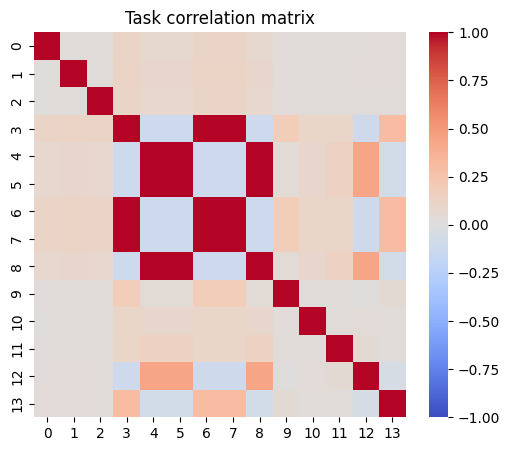

In [38]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(corr.cpu().numpy(), cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Task correlation matrix")
plt.show()

In [40]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()
    evals = torch.linalg.eigvalsh(B).flip(0)  # descending
    print(evals[:10])
    print("ratio e3/e2:", (evals[2] / evals[1]).item())


tensor([49.9022, 25.8585, 14.8057, 12.2694, 12.1121, 11.5261,  7.6260,  7.1813,
         5.7014,  5.5075])
ratio e3/e2: 0.5725640058517456


14.8057 / 25.8585 = 52 therefore rank‑3 could still capture meaningful structure

In [52]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor

    # Correct kappa
    kappa = task.var  # <-- correct

    B_lr = W @ W.t()
    B_d  = torch.diag(kappa)
    B    = B_lr + B_d

    frac_diag = torch.trace(B_d) / torch.trace(B)
    marg = torch.diag(B)
    frac_diag_per_task = kappa / marg

    print("Fraction diagonal:", frac_diag.item())
    print("diag fraction per task (min/mean/max/median):",
          frac_diag_per_task.min().item(),
          frac_diag_per_task.mean().item(),
          frac_diag_per_task.max().item(), 
          frac_diag_per_task.median().item()
          )
    print("first 10:", frac_diag_per_task[:])



Fraction diagonal: 0.5251065492630005
diag fraction per task (min/mean/max/median): 3.339092245369102e-06 0.5385887026786804 0.9783674478530884 0.7990060448646545
first 10: tensor([9.7837e-01, 9.7522e-01, 9.7814e-01, 3.3391e-06, 1.8897e-05, 3.5320e-06,
        9.1048e-06, 6.1302e-06, 9.0806e-06, 9.6045e-01, 9.7780e-01, 9.6835e-01,
        7.9901e-01, 9.0287e-01])


In [53]:
frac = frac_diag_per_task.detach().cpu()
idx = torch.argsort(frac)  # lowest = most shared
for i in idx:
    print(i.item(), float(frac[i]))


3 3.339092245369102e-06
5 3.532011078277719e-06
7 6.130182555352803e-06
8 9.0806433945545e-06
6 9.104773198487237e-06
4 1.8897313566412777e-05
12 0.7990060448646545
13 0.9028667211532593
9 0.9604512453079224
11 0.9683494567871094
1 0.9752171635627747
10 0.9777972102165222
2 0.9781361818313599
0 0.9783674478530884


In [55]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor  # [L, r]
    print("W (per-task loadings):")
    print(W)


W (per-task loadings):
Parameter containing:
tensor([[-1.5148e-01, -4.9295e-01],
        [-1.9737e-01, -5.2347e-01],
        [-1.6324e-01, -4.9623e-01],
        [ 9.6837e-01, -2.6312e+00],
        [-3.6457e+00, -8.9967e-01],
        [-3.6454e+00, -8.9734e-01],
        [ 9.6700e-01, -2.6325e+00],
        [ 9.6772e-01, -2.6305e+00],
        [-3.6459e+00, -8.9705e-01],
        [ 3.0250e-03, -4.8765e-01],
        [-1.4076e-01, -3.2648e-01],
        [-2.8603e-01, -4.1166e-01],
        [-2.0497e+00, -2.5160e-01],
        [ 4.4053e-01, -7.8546e-01]], requires_grad=True)


In [ ]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor  # [L, r]

    if hasattr(task, "raw_var") and hasattr(task, "raw_var_constraint"):
        kappa = task.raw_var_constraint.transform(task.raw_var)
    else:
        kappa = task.var  # fallback

    B_lr = W @ W.t()
    B_d  = torch.diag(kappa)
    B    = B_lr + B_d

    print("trace low-rank / trace total =", (torch.trace(B_lr) / torch.trace(B)).item())
    print("||B_lr||_F / ||B_total||_F =", (torch.linalg.norm(B_lr) / torch.linalg.norm(B)).item())
    print("frac diag =", (torch.trace(B_d) / torch.trace(B)).item())


trace low-rank / trace total = 0.4748935401439667
||B_lr||_F / ||B_total||_F = 0.8508837819099426
frac diag = 0.5251065492630005


In [57]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()  # <-- important

    evals, evecs = torch.linalg.eigh(B)  # ascending
    evals = torch.flip(evals, dims=[0])
    evecs = torch.flip(evecs, dims=[1])  # columns aligned with evals

print("Top eigenvalues:", evals[:5])
print("Top eigenvectors (first 3 modes):")
print(evecs[:, :3])


Top eigenvalues: tensor([49.9022, 25.8585, 14.8057, 12.2694, 12.1121])
Top eigenvectors (first 3 modes):
tensor([[-3.8322e-02, -1.6681e-01, -5.4603e-02],
        [-4.7590e-02, -1.7916e-01, -7.8472e-02],
        [-4.0695e-02, -1.6963e-01, -6.2682e-02],
        [ 8.6088e-02, -5.2043e-01,  5.8153e-02],
        [-5.1069e-01, -7.8974e-02, -2.3265e-01],
        [-5.1060e-01, -7.8543e-02, -2.3262e-01],
        [ 8.5880e-02, -5.2063e-01,  5.8064e-02],
        [ 8.6012e-02, -5.2027e-01,  5.8112e-02],
        [-5.1067e-01, -7.8475e-02, -2.3265e-01],
        [-9.0580e-03, -1.1854e-01, -6.9945e-04],
        [-2.7863e-02, -7.4014e-02, -1.4987e-02],
        [-5.4326e-02, -1.0038e-01, -3.8866e-02],
        [-4.2819e-01,  1.0312e-02,  8.9982e-01],
        [ 5.4503e-02, -2.2460e-01,  5.4961e-02]])


# adding ind gp 